In [1]:
import pandas as pd
import re
import glob
import warnings

warnings.filterwarnings("ignore")

In [2]:
def load_hogar_ccaa_data(
    path_pattern: str = '../../datamarts/picotaData_supercategory/hogarCCAA*.tsv',
    sort_by_ccaa: bool = True,
    ccaa_column_name: str = 'ccaa'
) -> pd.DataFrame:
    """
    Lee todos los ficheros TSV de hogares por CCAA, añade una columna con el código
    de CCAA extraído del nombre de fichero, concatena todo en un único DataFrame y
    opcionalmente ordena por CCAA.

    Parameters
    ----------
    path_pattern : str
        Patrón glob para localizar los archivos (por defecto '../../datamarts/picotaData/hogarCCAA*.tsv').
    sort_by_ccaa : bool
        Si True, ordena el DataFrame resultante por la columna de CCAA.
    ccaa_column_name : str
        Nombre de la columna donde se almacenará el código de CCAA.

    Returns
    -------
    pd.DataFrame
        DataFrame con todos los datos concatenados y la columna de CCAA.
    """
    files = glob.glob(path_pattern)
    dfs = []

    for fp in files:
        m = re.search(r'hogarCCAA(\d+)\.tsv$', fp)
        if not m:
            continue
        code = m.group(1).zfill(2)  # si quieres siempre dos dígitos, ojo

        df = pd.read_csv(fp, sep='\t')
        df[ccaa_column_name] = code
        dfs.append(df)

    if not dfs:
        raise FileNotFoundError(f"No se encontraron archivos con patrón {path_pattern}")

    big_df = pd.concat(dfs, ignore_index=True)

    if sort_by_ccaa:
        big_df.sort_values(ccaa_column_name, inplace=True)

    return big_df



In [3]:
df = load_hogar_ccaa_data()
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
df.head()

timestamp  capitalProvincia  tamanoMunicipio  densidad  \
0     2006-01-01T00:00:00                 0                3         1   
6476  2015-01-01T00:00:00                 1                5         3   
6477  2015-01-01T00:00:00                 0                5         3   
6478  2015-01-01T00:00:00                 1                5         3   
6479  2015-01-01T00:00:00                 0                3         1   

      superficie  aguaCaliente  calefaccion  zonaResidencial  regimenTenencia  \
0           90.0             1            0                5                6   
6476       150.0             1            0                5                2   
6477        85.0             1            0                5                6   
6478        75.0             1            0                5                5   
6479        90.0             1            1                5                6   

      comidasTotales  miembros:ocupados  miembros:noOcupados  \
0               68.0                3.0                    2   
6476            78.0                1.0                    2   
6477           112.0                1.0                    3   
6478            72.0                1.0                    2   
6479           110.0                1.0                    3   

      miembros:activos  miembros:noActivos  miembros:ancianos:masculinos  \
0                  3.0                   2                             0   
6476               2.0                   1                             0   
6477               2.0                   2                             0   
6478               2.0                   1                             0   
6479               2.0                   2                             0   

      miembros:ancianos:femeninos  miembros:adultos:masculinos  \
0                               0                            0   
6476                            0                            1   
6477                            0                            1   
6478                            0                            1   
6479                            0                            1   

      miembros:adultos:femeninos  miembros:niños:femeninos  \
0                              2                         1   
6476                           1                         1   
6477                           1                         0   
6478                           1                         1   
6479                           1                         0   

      miembros:niños:masculinos  miembros:conIngresos:masculinos  \
0                             2                                2   
6476                          0                                1   
6477                          2                                0   
6478                          0                                1   
6479                          2                                1   

      miembros:conIngresos:femeninos  miembros:sinIngresos:masculinos  \
0                                  1                                0   
6476                               1                                0   
6477                               1                                3   
6478                               1                                0   
6479                               1                                2   

      miembros:sinIngresos:femeninos  edadSp  espanolSp  educacionSuperiorSp  \
0                                  2      47          1                    0   
6476                               1      53          1                    1   
6477                               0      43          1                    1   
6478                               1      61          1                    0   
6479                               0      49          1                    0   

     fuentePrincipalIngresos  numeroViviendasAdicionales  ingresosNetos  \
0                 asalariado                         0.0   25097.315

In [4]:
df = pd.get_dummies(df, columns=['ccaa', 'fuentePrincipalIngresos'], prefix=['ccaa', 'fuentePrincipalIngresos'])

# Renombrar las columnas de CCAA para que tengan un formato más amigable
df.rename(columns=lambda x: re.sub(r'^ccaa_(\d+)$', r'ccaa_\1', x), inplace=True)
# Renombrar las columnas de fuentePrincipalIngresos para que tengan un formato más amigable
df.rename(columns=lambda x: re.sub(r'^fuentePrincipalIngresos_(\d+)$', r'fuentePrincipalIngresos_\1', x), inplace=True)


In [ ]:
df.head()

## Analísis de sensibilidad por código

### 🗂 Categorías por código (Super_Categoría)

| Código | Grupo de Gasto |
|--------|----------------|
| 1 | Alimentos y bebidas no alcohólicas |
| 2 | Bebidas alcohólicas, tabaco y narcóticos |
| 3 | Artículos de vestir y calzado |
| 4 | Vivienda, agua, electricidad, gas y otros combustibles |
| 5 | Mobiliario, equipamiento del hogar y gastos de conservación |
| 6 | Salud |
| 7 | Transportes |
| 8 | Comunicaciones |
| 9 | Ocio, espectáculos y cultura |
| 10 | Enseñanza |
| 11 | Hoteles, cafés y restaurantes |
| 12 | Otros bienes y servicios |



Hacemos un sondeo para ver que variables de salida nos pueden ayudar a predecir nuestro modelo

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
def select_features(X, y, vif_thresh, p_thresh):
    """
    Elimina iterativamente la variable con p-valor > p_thresh
    o VIF > vif_thresh hasta que todas las variables cumplan ambos criterios.
    """
    X = X.copy()
    while True:
        # 1) Eliminación por p-valor
        X_const = sm.add_constant(X, has_constant='add')
        model = sm.OLS(y, X_const).fit()
        pvals = model.pvalues.drop('const', errors='ignore')
        if not pvals.empty and pvals.max() > p_thresh:
            drop_var = pvals.idxmax()
            X = X.drop(columns=[drop_var])
            continue

        # 2) Eliminación por VIF
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )
        if vif.max() > vif_thresh:
            drop_var = vif.idxmax()
            X = X.drop(columns=[drop_var])
            continue

        break

    return X

In [7]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


def run_sensitivity_analysis_by_category(df, output_columns,
                                         p_value_threshold=0.05,
                                         vif_threshold=5,
                                         normalize=True):
    model_results = {}
    significant_coefficients = []
    model_metrics = []
    discarded = []

    # Excluir variables de salida y otras no deseadas de los predictores
    excluded = set(["timestamp"]) | set(output_columns)
    expl = [c for c in df.select_dtypes(include="number").columns if c not in excluded]

    for target in output_columns:
        # Verificar existencia de la variable target
        if target not in df.columns:
            discarded.append((target, "No existe en el DataFrame"))
            continue

        # Eliminar filas con NA en target o en predictores base
        d = df.dropna(subset=[target] + expl)
        if d.shape[0] < len(expl) + 5:
            discarded.append((target, "Insuficientes datos"))
            continue

        X = d[expl]
        y = d[target]

        # Normalizar si se solicita
        if normalize:
            scaler = StandardScaler()
            X = pd.DataFrame(scaler.fit_transform(X),
                             columns=X.columns, index=X.index)

        try:
            # Selección de características por VIF y p-valor
            if vif_threshold is not None:
                X_sel = select_features(X, y, vif_threshold, p_value_threshold)
            else:
                X_sel = X.copy()

            if X_sel.shape[1] == 0:
                discarded.append((target, "Sin variables finales"))
                continue

            # Ajuste del modelo OLS
            X_const = sm.add_constant(X_sel, has_constant='add')
            m = sm.OLS(y, X_const).fit()
            model_results[target] = m

            # Guardar coeficientes significativos
            coefs = pd.DataFrame({
                "Variable": m.params.index,
                "Coeficiente": m.params.values,
                "P-Valor": m.pvalues.values,
                "Gasto": target
            })
            coefs = coefs[(coefs["P-Valor"] < p_value_threshold) & (coefs["Variable"] != "const")]
            significant_coefficients.append(coefs)

            print(f"Modelo para {target}: R² = {m.rsquared:.4f}, R² Ajustado = {m.rsquared_adj:.4f}")


            # Guardar métricas del modelo
            model_metrics.append({
                "Gasto": target,
                "R²": m.rsquared,
                "R² Ajustado": m.rsquared_adj,
                "AIC": m.aic,
                "BIC": m.bic,
                "N": int(m.nobs)
            })

        except Exception as e:
            discarded.append((target, f"Error: {e}"))

    # Concatenar y ordenar resultados
    coefs_df = pd.concat(significant_coefficients, ignore_index=True) if significant_coefficients else pd.DataFrame()
    metrics_df = pd.DataFrame(model_metrics).sort_values("R² Ajustado", ascending=False)

    return model_results, coefs_df, metrics_df, discarded


In [8]:
output_columns = [col for col in df.columns if col.startswith("gastoMonetario:")]


In [9]:
results, coef_df, metrics_df, discarded = run_sensitivity_analysis_by_category(
    df,
    output_columns,
    p_value_threshold=0.05,   
    vif_threshold=5,       
    normalize=True        
)


Modelo para gastoMonetario:alimentosYBebidasNoAlcoholicas1: R² = 0.2814, R² Ajustado = 0.2810
Modelo para gastoMonetario:bebidasAlcoholicasYTabaco2: R² = 0.0463, R² Ajustado = 0.0459
Modelo para gastoMonetario:ropaYCalzado3: R² = 0.1138, R² Ajustado = 0.1134
Modelo para gastoMonetario:viviendaAguaElectricidadGasOtrosCombustibles4: R² = 0.2248, R² Ajustado = 0.2244
Modelo para gastoMonetario:mobiliarioEquipamientoDelHogarYGastosDeConservacion5: R² = 0.1724, R² Ajustado = 0.1720
Modelo para gastoMonetario:salud6: R² = 0.0356, R² Ajustado = 0.0352
Modelo para gastoMonetario:transportes7: R² = 0.1134, R² Ajustado = 0.1130
Modelo para gastoMonetario:comunicaciones8: R² = 0.1622, R² Ajustado = 0.1618
Modelo para gastoMonetario:ocioEspectaculosYCultura9: R² = 0.1567, R² Ajustado = 0.1563
Modelo para gastoMonetario:ensenanza10: R² = 0.2177, R² Ajustado = 0.2174
Modelo para gastoMonetario:hotelesCafesYRestaurantes11: R² = 0.2596, R² Ajustado = 0.2592
Modelo para gastoMonetario:otrosBienesYServi

In [10]:
metrics_df

Gasto        R²  R² Ajustado  \
0      gastoMonetario:alimentosYBebidasNoAlcoholicas1  0.281377     0.281045   
10         gastoMonetario:hotelesCafesYRestaurantes11  0.259564     0.259248   
3   gastoMonetario:viviendaAguaElectricidadGasOtro...  0.224788     0.224440   
9                          gastoMonetario:ensenanza10  0.217727     0.217355   
4   gastoMonetario:mobiliarioEquipamientoDelHogarY...  0.172435     0.171998   
7                      gastoMonetario:comunicaciones8  0.162168     0.161803   
8            gastoMonetario:ocioEspectaculosYCultura9  0.156724     0.156290   
11             gastoMonetario:otrosBienesYServicios12  0.115136     0.114704   
2                        gastoMonetario:ropaYCalzado3  0.113798     0.113365   
6                         gastoMonetario:transportes7  0.113366     0.113004   
1           gastoMonetario:bebidasAlcoholicasYTabaco2  0.046284     0.045881   
5                               gastoMonetario:salud6  0.035561     0.035218   

             AIC           BIC      N  
0   1.390505e+06  1.390838e+06  75819  
10  1.421827e+06  1.422131e+06  74996  
3   1.352800e+06  1.353123e+06  75819  
9   1.339346e+06  1.339688e+06  75819  
4   1.385795e+06  1.386174e+06  75819  
7   1.171952e+06  1.172266e+06  75819  
8   1.406646e+06  1.407016e+06  75819  
11  1.412543e+06  1.412894e+06  75818  
2   1.395657e+06  1.396008e+06  75819  
6   1.526484e+06  1.526779e+06  75819  
1   1.235015e+06  1.235320e+06  75819  
5   1.395276e+06  1.395535e+06  75819

### 📊 Interpretación de los resultados del modelo OLS por categoría de gasto

Cada modelo OLS estima el gasto en una **supercategoría** a partir de variables explicativas como edad, ingresos, tipo de hogar, zona, etc. Para evaluar la calidad del ajuste del modelo, se analiza principalmente:

---

#### 🔹 **R² (Coeficiente de determinación)**
- Indica la proporción de la variabilidad del gasto explicada por el modelo.
- Va de 0 a 1: cuanto más alto, mejor.

**Ejemplos:**
- `ALQUILERES_IMPUTADOS_DE_LA_VIVIENDA` tiene un **R² de 0.65** → el modelo explica el **65%** de la variabilidad en el gasto. Es un ajuste bastante bueno.
- `PRODUCTOS_ALIMENTICIOS` tiene un **R² de 0.24** → el modelo explica solo el **24%** del gasto. Aceptable, pero deja gran parte sin explicar.
- `SERVICIOS_FINANCIEROS` tiene un **R² de 0.01** → el modelo **no logra explicar prácticamente nada** del gasto en esta categoría.

---

#### 🔹 **R² ajustado**
- Penaliza la inclusión de variables irrelevantes. Muy útil cuando hay muchas variables predictoras.
- Si es similar al R², indica que las variables añadidas aportan información real.

---

### ✅ Conclusiones de los resultados obtenidos

- 💡 **El modelo predice bien ciertas categorías estructurales y regulares del hogar:**
  - `ALQUILERES_IMPUTADOS_DE_LA_VIVIENDA`: R² = **0.65**
  - `SUMINISTRO_DE_AGUA`: R² = **0.29**
  - `ALQUILERES_REALES_DE_LA_VIVIENDA`: R² = **0.29**
  - `ELECTRICIDAD_GAS_OTROS_COMBUSTIBLES`: R² = **0.28**

  Estas categorías están probablemente determinadas por factores socioeconómicos (ingresos, tamaño del hogar, localización), lo cual el modelo capta con eficacia.

- 🟡 **Otras categorías muestran un ajuste moderado:**
  - `PRODUCTOS_ALIMENTICIOS`: R² = **0.24**
  - `SEGUROS`: R² = **0.23**
  - `EDUCACIÓN_INFANTIL_PRIMARIA`: R² = **0.23**

  Son áreas donde el comportamiento del gasto es más complejo, pero todavía parcialmente explicado por las variables del modelo.

- ❌ **Muchas categorías tienen un ajuste bajo (R² < 0.10):**
  - `CALZADO`, `TABACO`, `OCIO`, `EFECTOS_PERSONALES`, `SERVICIOS_POSTALES`, `SERVICIOS_MÉDICOS`, etc.

  En estos casos, el gasto puede depender de factores no observados en el modelo (gustos, hábitos, salud, eventos puntuales, etc.), o ser tan variable que no se puede modelar fácilmente con regresión lineal.

---

Como vemos, el modelo OLS es útil para estimar **gastos básicos y sistemáticos del hogar**, pero tiene **limitaciones claras** en categorías personales, esporádicas o con bajo gasto. Para estas últimas, podrían explorarse modelos no lineales, técnicas de segmentación o incluso análisis cualitativos.


### Graficamos los coeficientes por categoría

In [11]:
import matplotlib.pyplot as plt
import re

def plot_coefficients_per_category(coefficients_df):
    """
    Genera un gráfico de barras por cada categoría de gasto (columna 'Gasto'),
    ordenada según el número que aparece al final de la cadena.
    Barras rojas para coeficientes positivos, azules para negativos.
    """
    # 1) Extraemos el código numérico al final de cada categoría
    codes = (
        coefficients_df[['Gasto']]
        .drop_duplicates()
        .assign(
            Codigo=lambda d: (
                d['Gasto']
                .str.extract(r'(\d+)$')[0]         # captura los dígitos finales
                .astype(int, errors='ignore')     # convierte a int
            )
        )
    )

    # 2) Eliminamos posibles filas sin código válido y ordenamos
    ordered = (
        codes
        .dropna(subset=['Codigo'])
        .sort_values('Codigo')
        ['Gasto']
        .tolist()
    )

    # 3) Para cada categoría, dibujamos su barra
    for categoria in ordered:
        df_cat = coefficients_df[coefficients_df['Gasto'] == categoria]
        if df_cat.empty:
            continue

        # Color según signo del coeficiente
        df_cat = df_cat.copy()
        df_cat['Color'] = df_cat['Coeficiente'].apply(
            lambda x: 'darkred' if x > 0 else 'darkblue'
        )

        plt.figure(figsize=(12, 6))
        plt.bar(
            df_cat['Variable'],
            df_cat['Coeficiente'],
            color=df_cat['Color']
        )
        plt.axhline(0, color='black', linestyle='--')
        plt.xticks(rotation=90, ha='right')
        plt.title(f"Impacto de variables en: {categoria}")
        plt.xlabel("Variable explicativa")
        plt.ylabel("Coeficiente de regresión")
        plt.tight_layout()
        plt.show()


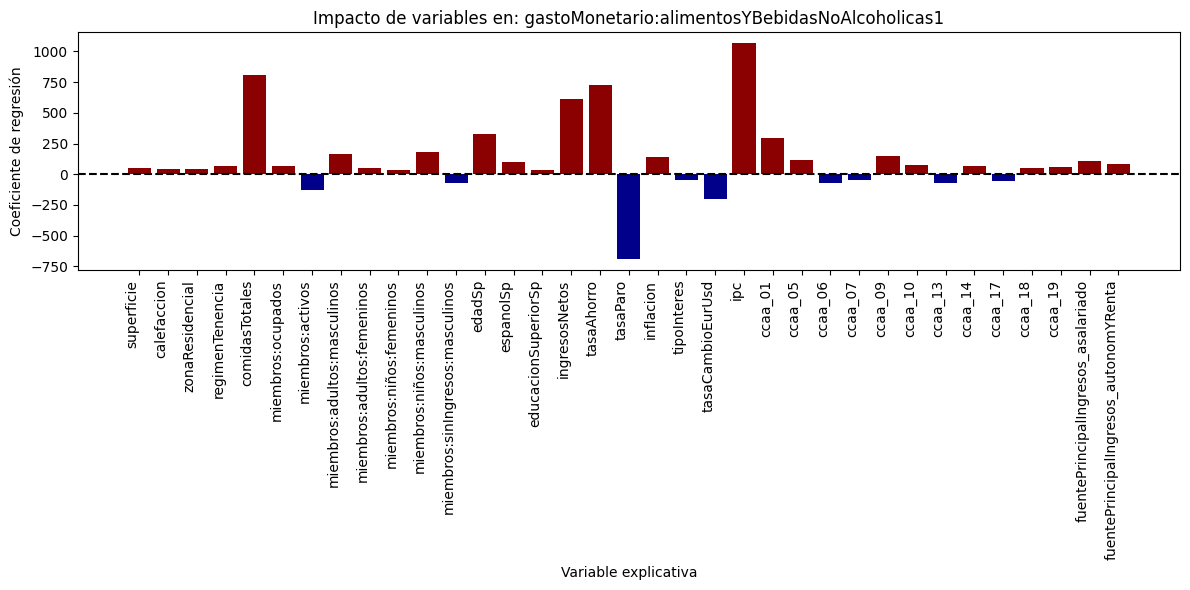

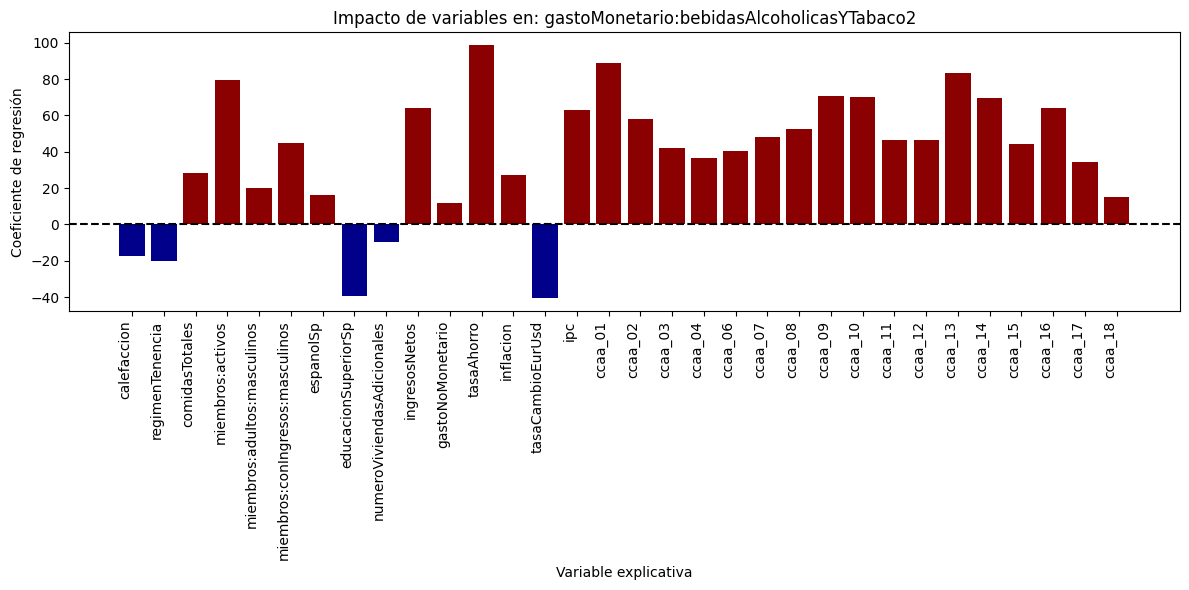

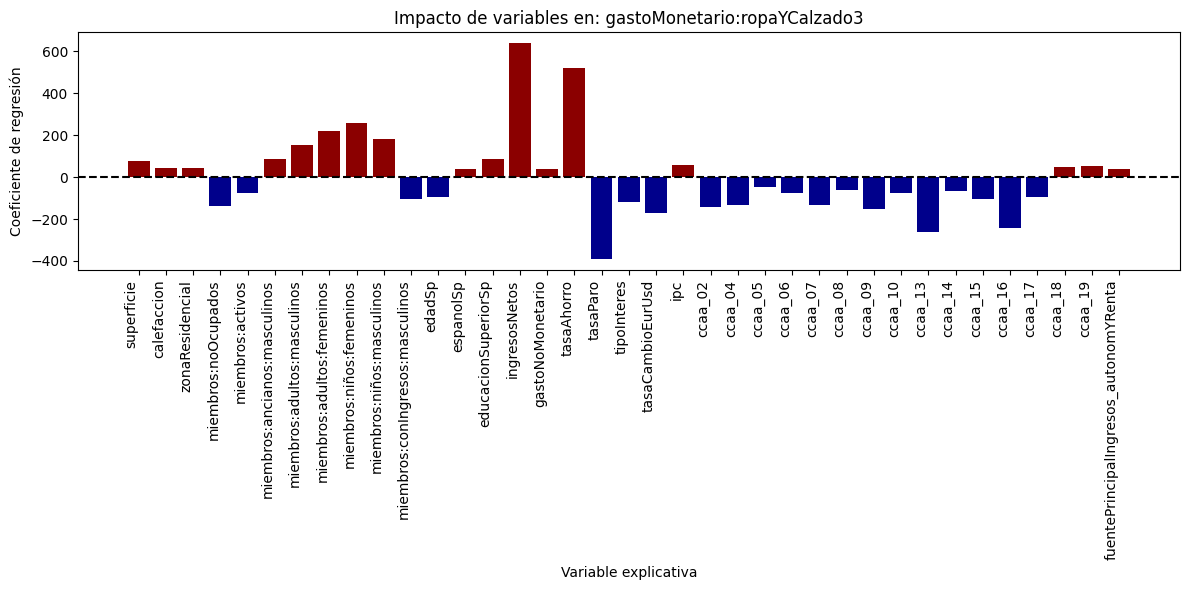

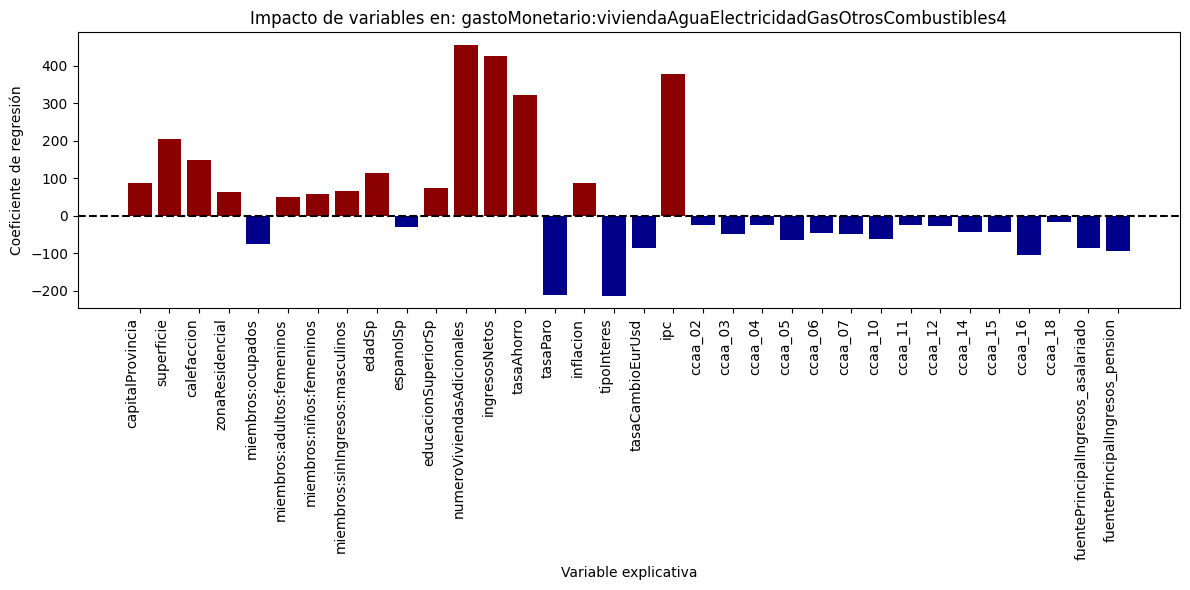

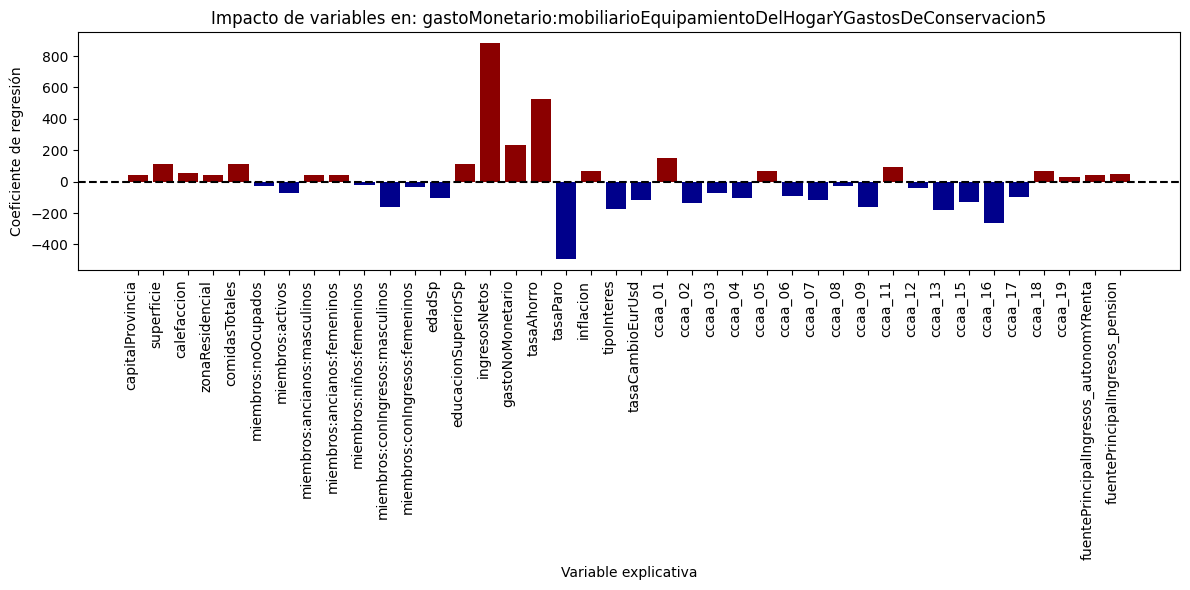

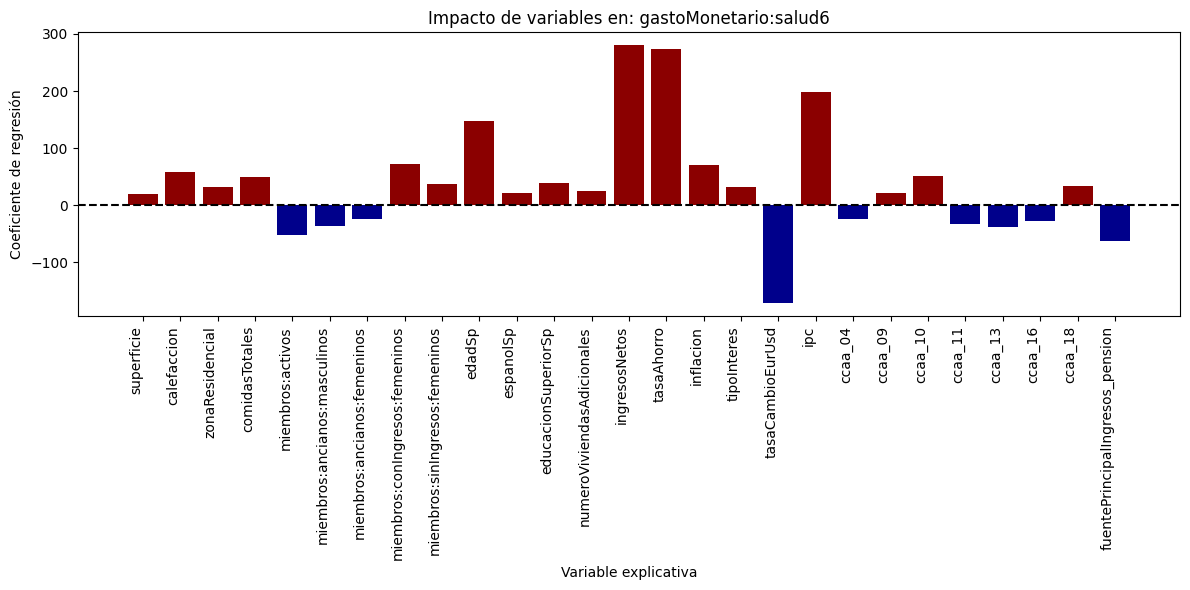

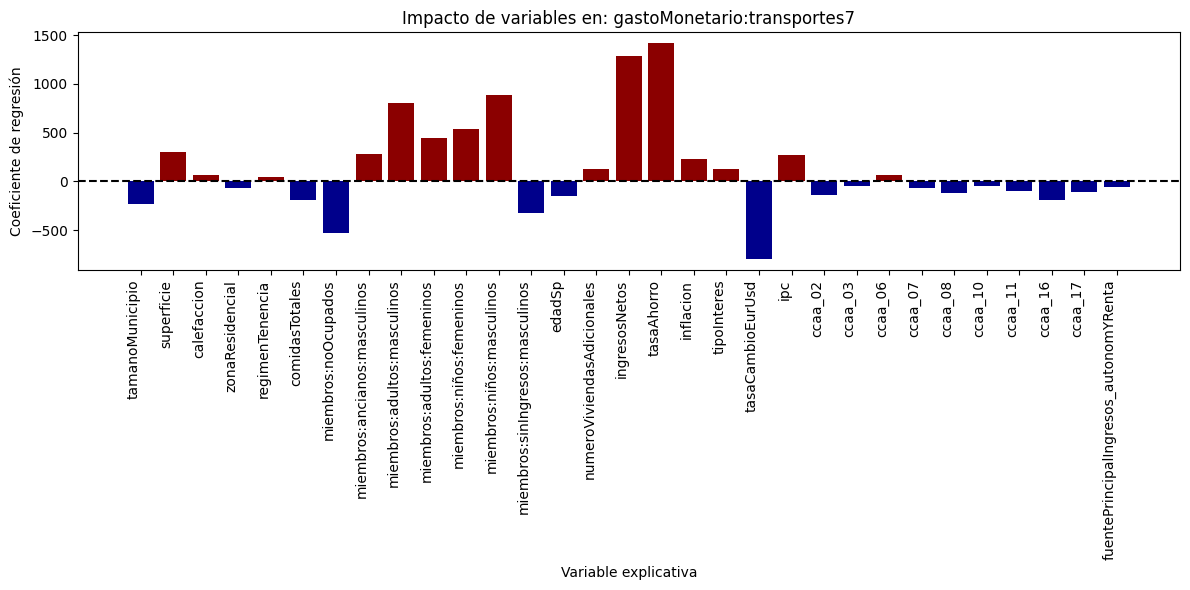

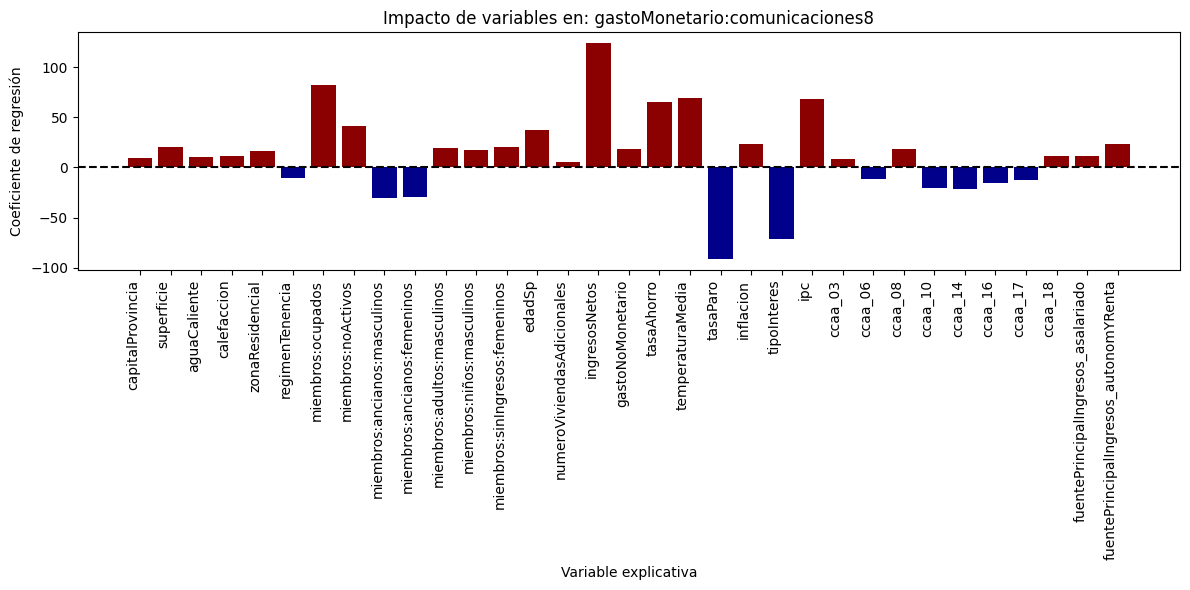

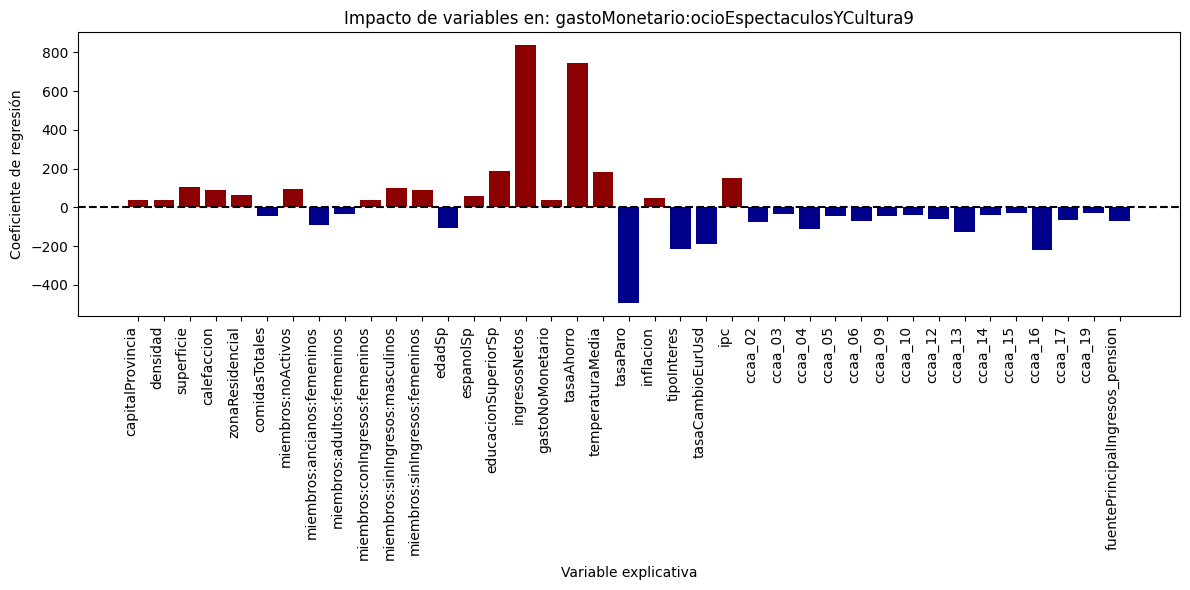

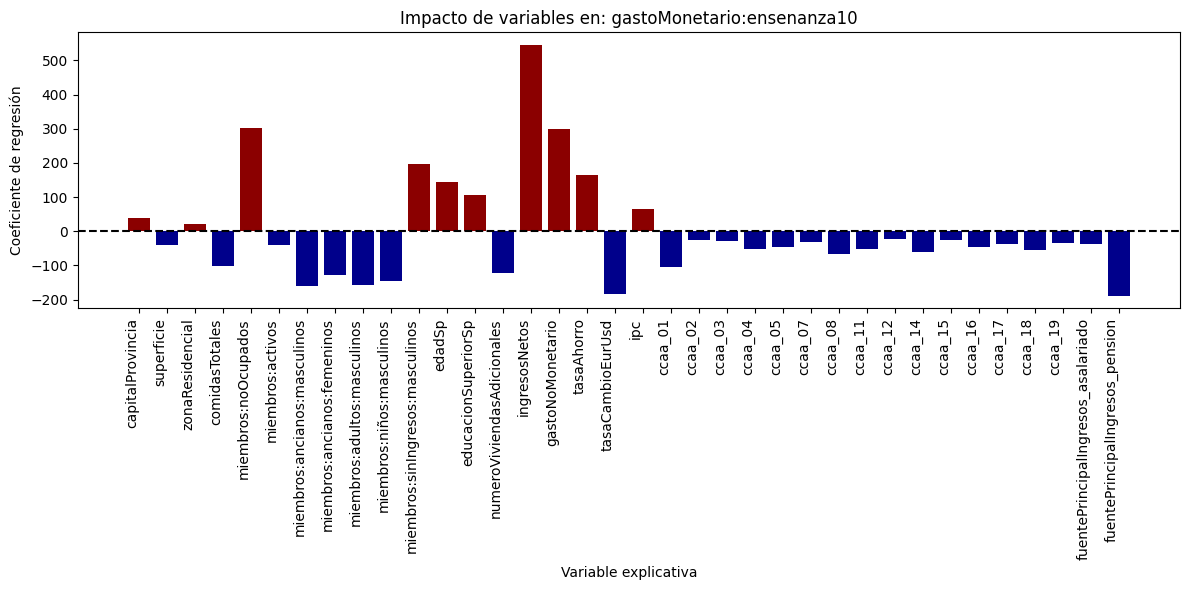

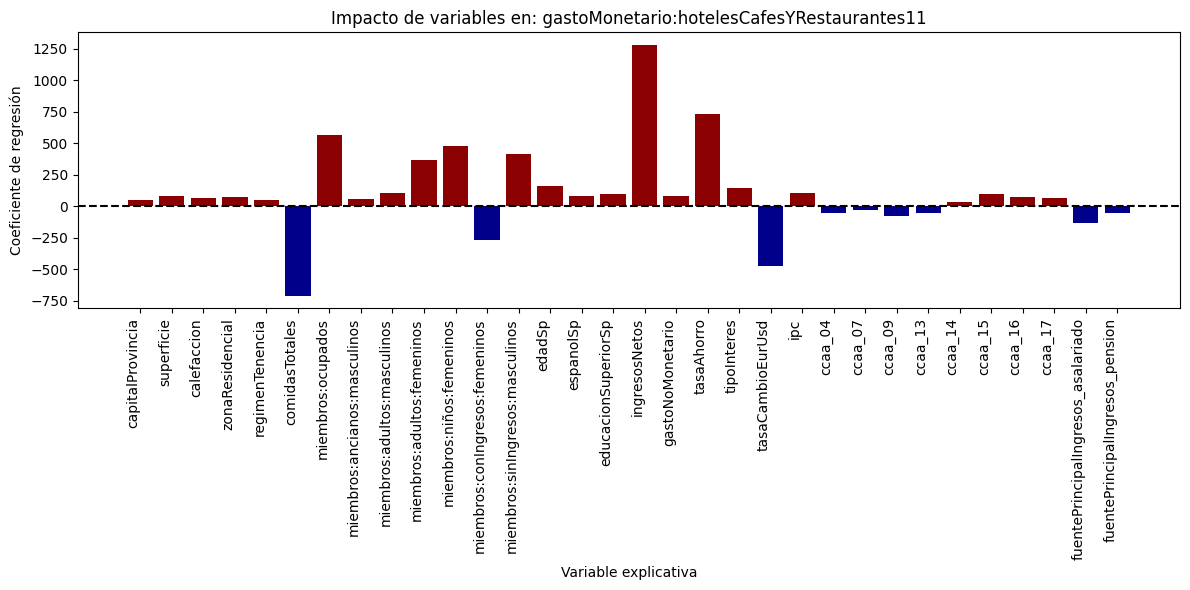

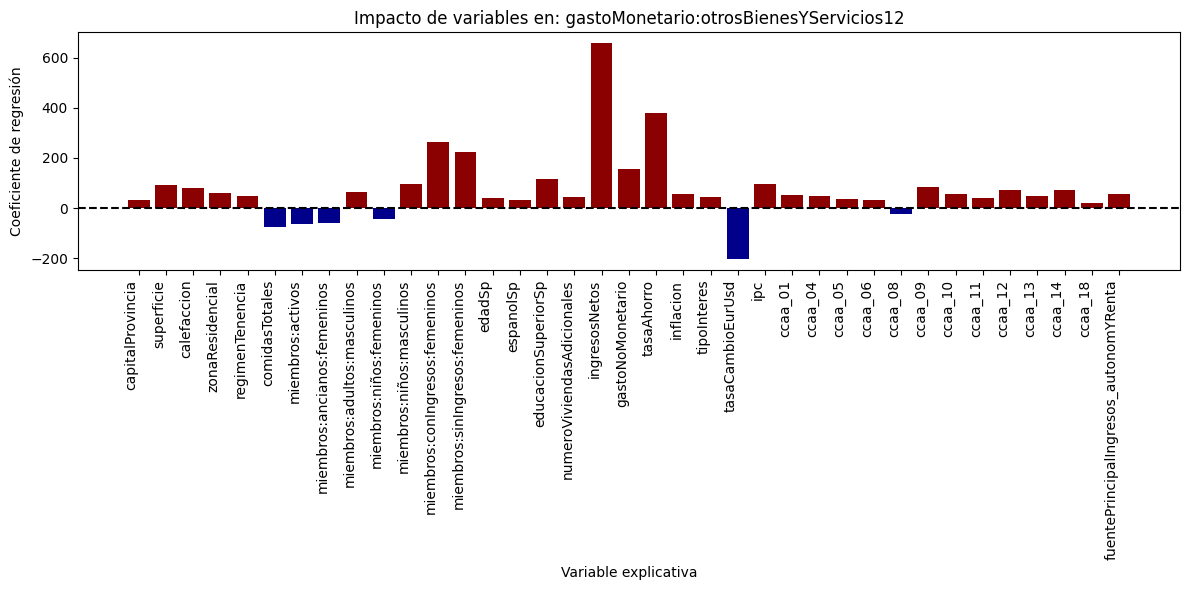

In [12]:
coefs_finales_without_const = coef_df[~coef_df["Variable"].str.contains("const")]

plot_coefficients_per_category(coefs_finales_without_const)

## 📐 Interpretación de un Modelo de Regresión Lineal Múltiple Normalizado

### 🔄 ¿Qué significa "normalizado"?

Cuando se normaliza un modelo, las variables se transforman para que tengan:

- **Media = 0**
- **Desviación estándar = 1**

Esta normalización se aplica a las variables explicativas (X), y opcionalmente también a la variable dependiente (y).

---

### 🎯 ¿Cómo se interpretan los coeficientes?

En un modelo normalizado, **los coeficientes se interpretan en términos de desviaciones estándar**:

> Un coeficiente indica cuántas desviaciones estándar cambia la variable dependiente por cada desviación estándar de cambio en la variable independiente, manteniendo las demás constantes.

---

### 💡 Ejemplo de interpretación

- Si el coeficiente de `IMPEXAC` es **+1.2**:
  - Entonces, **un aumento de 1 desviación estándar en los ingresos (`IMPEXAC`)** se asocia con un aumento de **1.2 desviaciones estándar en el gasto mensual**.

- Si el coeficiente de `NUMESTU` es **-0.5**:
  - Entonces, **un aumento de 1 desviación estándar en el número de estudiantes** se asocia con una **disminución de 0.5 desviaciones estándar en el gasto mensual**.

---

### ✅ Ventajas de la normalización

- Permite **comparar directamente el peso relativo de cada variable** en el modelo.
- Evita que variables con escalas más grandes dominen el modelo por su magnitud.
- Es útil en modelos con muchas variables heterogéneas (e.g. edad, ingresos, tamaño del hogar, etc.).

---

### ⚠️ Consideraciones

- Los coeficientes ya no están en unidades interpretables (euros, años, personas...).
- Solo tiene sentido si se desea analizar **la importancia relativa** de las variables, no el efecto real en magnitudes absolutas.


### Vemos un mapa de calor con el impacto real de cada variable en cada supercategoría

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_sign_colors_scaled(coefficients_df):
    # ——— 1) Preparar summary igual que antes ———
    codes = (
        coefficients_df[['Gasto']]
        .drop_duplicates()
        .assign(
            Codigo=lambda d: (
                d['Gasto']
                .str.extract(r'(\d+)$')[0]
                .astype(int, errors='ignore')
            )
        )
    )
    df = coefficients_df.merge(codes, on='Gasto', how='left')
    summary = df.pivot_table(
        index="Variable",
        columns="Codigo",
        values="Coeficiente"
    )
    # ordenar columnas numéricamente
    cols = sorted(summary.columns, key=int)
    summary = summary[cols]

    # ——— 2) Normalizar cada columna por su valor absoluto máximo ———
    max_per_col = summary.abs().max(axis=0)
    summary_norm = summary.divide(max_per_col, axis=1)

    # ——— 3) Dibujar heatmap con color por SIGNO+MAG relativa  ———
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    fig, ax = plt.subplots(figsize=(22, 14))

    sns.heatmap(
        summary_norm,           # datos normalizados entre -1 y 1
        cmap=cmap,
        center=0,
        vmin=-1,                # simétrico
        vmax=+1,
        linewidths=0.5,
        linecolor="grey",
        cbar_kws={"label": "Magnitud relativa\n(-1 a +1)"},
        annot=summary.abs(),    # anotamos con valor absoluto REAL
        fmt=".2f",
        annot_kws={"size": 8},
        ax=ax
    )

    # ——— 4) Ajustes de ejes y márgenes ———
    ax.set_title(
        "Coeficientes (|valor|) · Color = signo/magnitud relativa",
        fontsize=14, pad=20
    )
    ax.set_xlabel("Código de Categoría de Gasto", fontsize=12)
    ax.set_ylabel("Variable", fontsize=12)
    ax.tick_params(axis='y', labelsize=8)
    plt.xticks(rotation=45, ha="right")

    # más espacio a la izquierda para etiquetas largas
    plt.subplots_adjust(left=0.30, bottom=0.15)
    plt.tight_layout()
    plt.show()


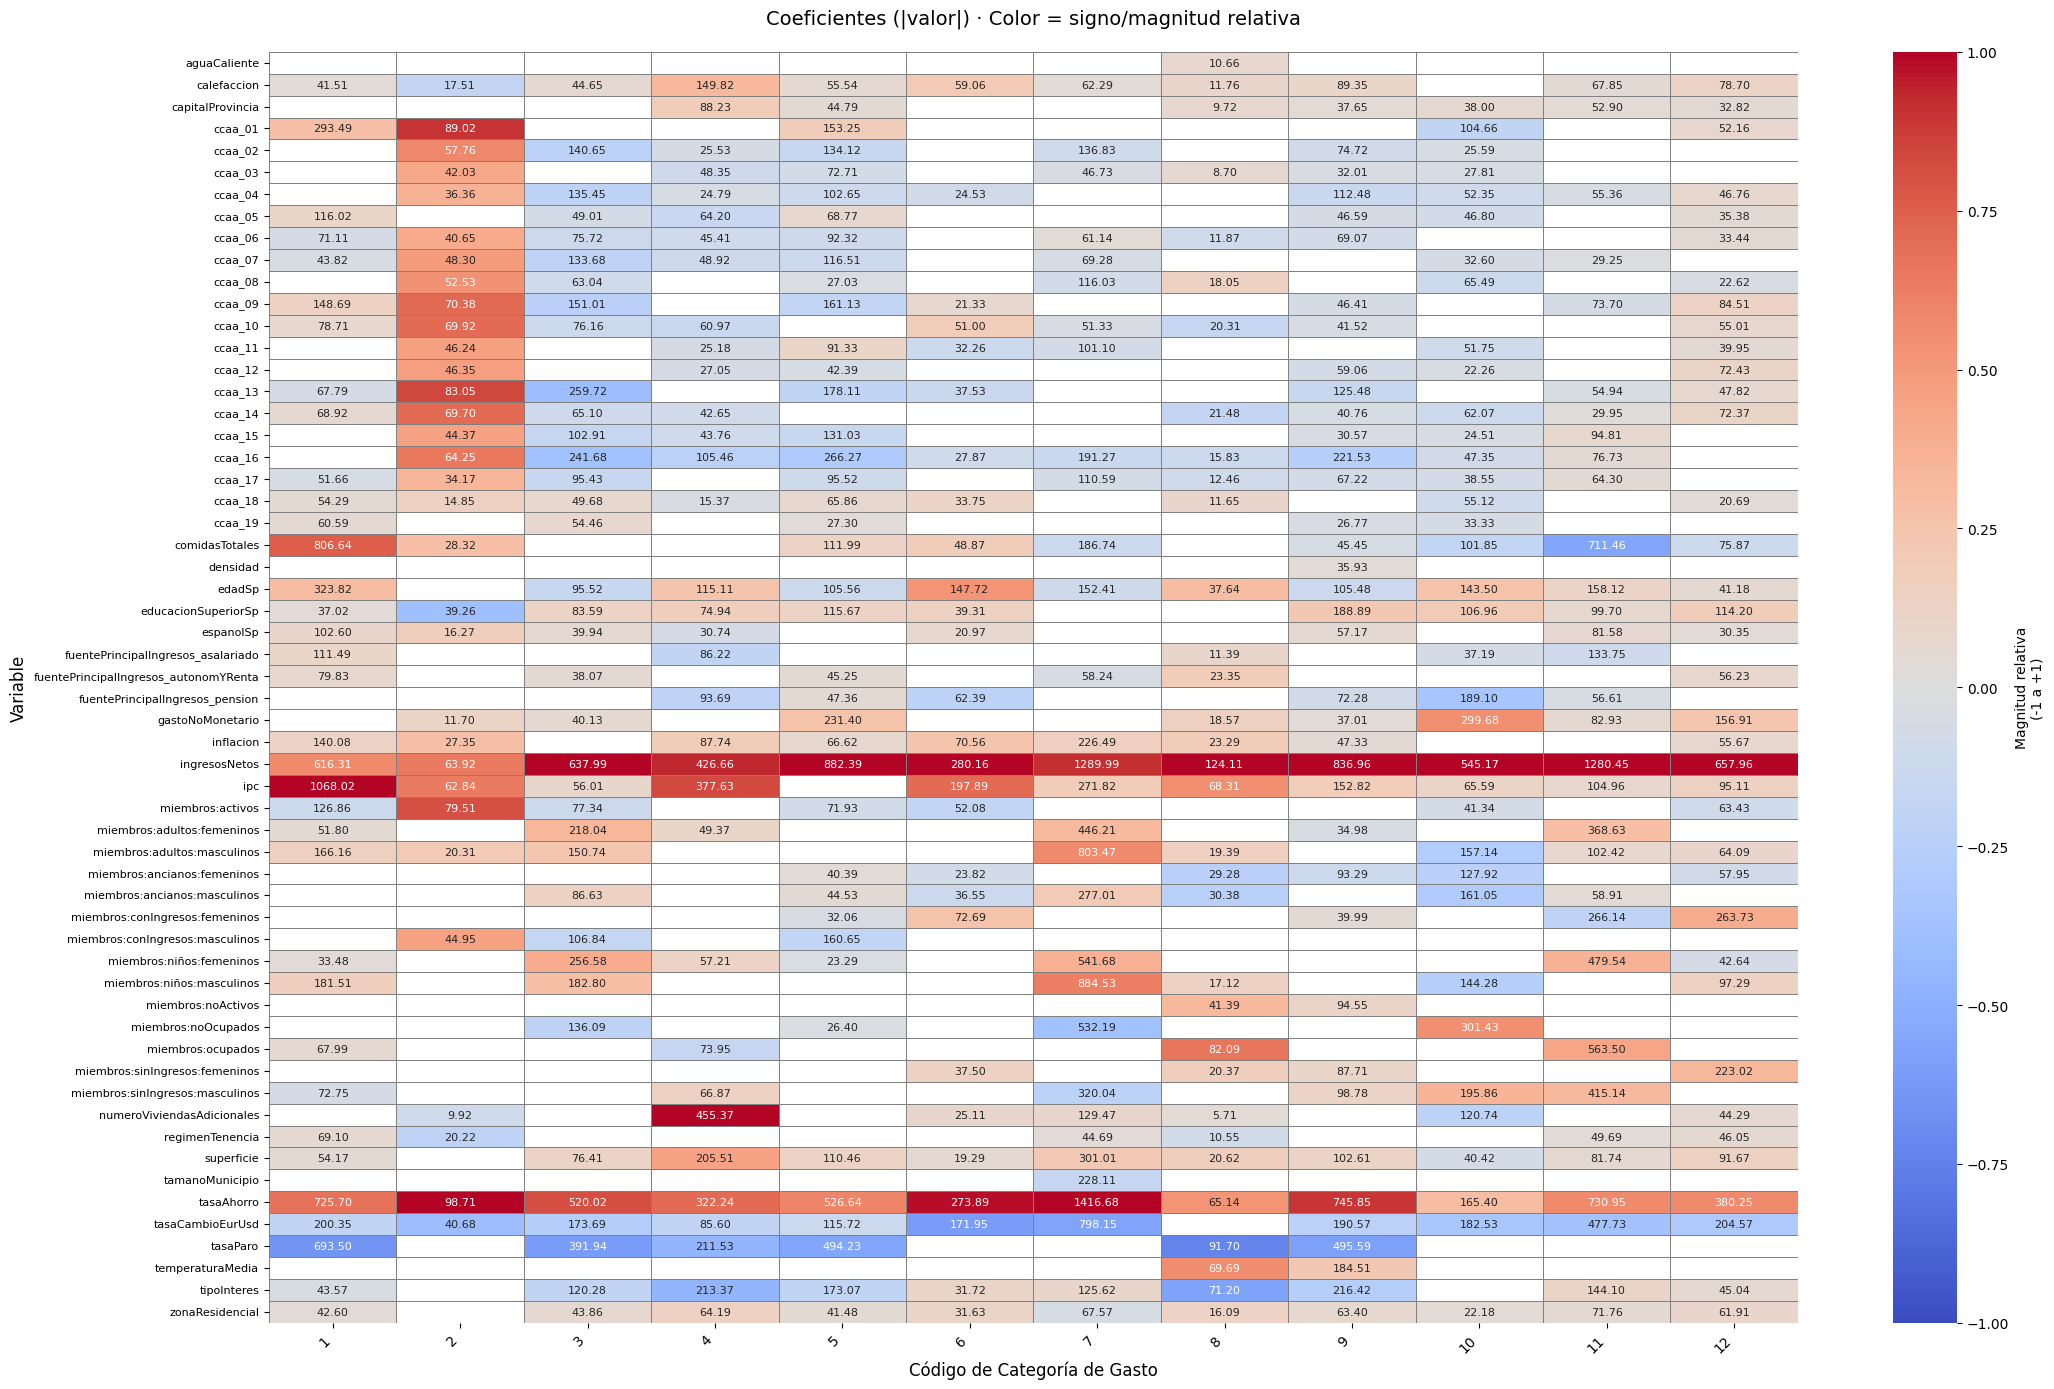

In [14]:
plot_heatmap_sign_colors_scaled(coefs_finales_without_const)

In [15]:
# Convert the coefficients DataFrame to a more readable format
coefs_finales_pivot = coef_df.pivot(index="Variable", columns="Gasto", values="Coeficiente")
coefs_finales_pivot

Gasto                                  gastoMonetario:alimentosYBebidasNoAlcoholicas1  \
Variable                                                                                
aguaCaliente                                                                      NaN   
calefaccion                                                                 41.507128   
capitalProvincia                                                                  NaN   
ccaa_01                                                                    293.487449   
ccaa_02                                                                           NaN   
ccaa_03                                                                           NaN   
ccaa_04                                                                           NaN   
ccaa_05                                                                    116.015632   
ccaa_06                                                                    -71.114497   
ccaa_07                                                                    -43.822198   
ccaa_08                                                                           NaN   
ccaa_09                                                                    148.686335   
ccaa_10                                                                     78.713491   
ccaa_11                                                                           NaN   
ccaa_12                                                                           NaN   
ccaa_13                                                                    -67.791351   
ccaa_14                                                                     68.916225   
ccaa_15                                                                           NaN   
ccaa_16                                                                           NaN   
ccaa_17                                                                    -51.655115   
ccaa_18                                                                     54.293704   
ccaa_19                                                                     60.587265   
comidasTotales                                                             806.640295   
densidad                                                                          NaN   
edadSp                                                                     323.815186   
educacionSuperiorSp                                                         37.021913   
espanolSp                                                                  102.599937   
fuentePrincipalIngresos_asalariado                                         111.494705   
fuentePrincipalIngresos_autonomYRenta                                       79.828395   
fuentePrincipalIngresos_pension                                                   NaN   
gastoNoMonetario                                                                  NaN   
inflacion                                                                  140.078169   
ingresosNetos                                                              616.306390   
ipc                                                                       1068.020432   
miembros:activos                                                          -126.857282   
miembros:adultos:femeninos                                                  51.803624   
miembros:adultos:masculinos                                                166.160371   
miembros:ancianos:femeninos                                                       NaN   
miembros:ancianos:masculinos                                                      NaN   
miembros:conIngresos:femeninos                                                    NaN   
miembros:conIngresos:masculinos                                                   NaN   
miembros:niños:femeninos                                                    33.478857   
miembros:niños:masculinos                                                  181.51049

# Análisis de Coeficientes OLS por Categoría de Gasto

Este análisis se basa en la matriz de coeficientes de modelos OLS aplicados a distintas **categorías de gasto**. Cada columna representa una categoría, y cada fila es una variable explicativa. Los valores indican la **magnitud y dirección del impacto** de esa variable sobre el gasto, manteniendo constantes las demás.

---

## 📊 Interpretación General

- **Coeficientes positivos**: sugieren que un aumento en la variable explicativa está asociado con un mayor gasto en esa categoría.
- **Coeficientes negativos**: indican que un aumento en la variable reduce el gasto en esa categoría.
- **Valores faltantes (`NaN`)**: la variable no resultó significativa o fue eliminada por multicolinealidad.

---

## 🔍 1. Variables con impacto sistemático

### 🏦 `Tipo_Interes`
- Presente en casi todas las categorías con coeficientes positivos.
- Altamente significativo en:
  - `ALQUILERES_IMPUTADOS`: +26.06
  - `ALQUILERES_REALES`: +20.54
  - `SERVICIOS_HOSPITALARIOS`: +21.85
- 📌 **Interpretación**: un aumento de los tipos de interés se asocia con un mayor gasto imputado y real en vivienda. Puede reflejar tanto un mayor coste de oportunidad de la vivienda como una mayor presión económica en hogares con hipoteca.

### 📉 `Tasa_Paro`
- Fuertemente negativo en gastos estructurales:
  - `ALQUILERES_IMPUTADOS`: -61.64
  - `ALQUILERES_REALES`: -34.90
- 📌 **Interpretación**: el desempleo tiene un impacto claro sobre el gasto, reduciendo notablemente el consumo en vivienda y otras categorías.

---

## 👨‍👩‍👧‍👦 2. Estructura del Hogar y Demografía

### `NUMPERI` (número de personas en el hogar)
- Negativo en:
  - `ALQUILERES_REALES`: -7.56
  - `ALQUILERES_IMPUTADOS`: -6.33
- Positivo en:
  - `CALZADO`: +1.68
  - `VEHÍCULOS_PERSONALES`: +4.45
- 📌 **Interpretación**: hogares grandes diluyen el gasto individual en vivienda, pero aumentan el consumo en necesidades grupales.

### `TAMAMU` (tamaño del municipio)
- Positivo en:
  - `ALQUILERES_IMPUTADOS`: +12.42
  - `ALQUILERES_REALES`: +16.82
  - `VEHÍCULOS_PERSONALES`: -10.47 (negativo)
- 📌 **Interpretación**: los municipios grandes implican mayor gasto en vivienda y menor dependencia del transporte privado.

### `ZONARES` (zona residencial)
- Positivo en vivienda:
  - `ALQUILERES_IMPUTADOS`: +13.51
  - `ALQUILERES_REALES`: +13.87
- 📌 **Interpretación**: residir en ciertas zonas eleva significativamente el coste (o el gasto declarado) en vivienda.

---

## 🎓 3. Educación y situación laboral

### `EDUC_SUPERIOR`
- Coeficientes altos y positivos en múltiples categorías:
  - `ALQUILERES_IMPUTADOS`: +12.08
  - `ALQUILERES_REALES`: +13.69
  - `ALOJAMIENTO`: +10.92
- 📌 **Interpretación**: mayor nivel educativo se asocia con mayor capacidad de gasto y posiblemente con patrones de consumo más intensivos.

### `OCUSP` (persona ocupada)
- Positivo en:
  - `ALQUILERES_REALES`: +13.05
  - `CALZADO`: +2.57
  - `ARTÍCULOS_DE_VESTIR`: +5.40
- 📌 **Interpretación**: el empleo está relacionado con un mayor gasto en consumo visible y vivienda.

---

## 👧👦 4. Presencia de menores

### `NNINO_FEM`, `NNINO_MAS`
- Fuertemente positivos en categorías como:
  - `ARTÍCULOS_DE_VESTIR`: +10.05 (`NNINO_FEM`)
  - `CALZADO`: +2.93 (`NNINO_MAS`)
  - `OCIO`: +3–5 puntos
- 📌 **Interpretación**: los menores impactan directamente en el consumo de ropa, calzado, ocio y educación.

---

## 🧓 5. Presencia de mayores

### `NADUL_FEM`, `NADUL_MAS`
- Tienen impactos **negativos** en muchas categorías:
  - `ALQUILERES_REALES`: -7.08 (`NADUL_MAS`)
  - `BIENES_SERVICIOS_HOGAR`: -9.81
- 📌 **Interpretación**: hogares con adultos mayores tienden a reducir el gasto, posiblemente por restricciones económicas o cambios en estilo de vida.

---

## 🌡️ 6. Clima y condiciones ambientales

### `Tmax_max`, `Tmin_min`
- Positivo en:
  - `SERVICIOS_HOSPITALARIOS`: +11.65
  - `OCIO`, `TEXTILES`, etc.
- 📌 **Interpretación**: temperaturas extremas podrían inducir mayor gasto en salud y acondicionamiento del hogar.

---

## 📦 7. Variables singulares

### `DISPOSIOV`
- Coeficiente extremadamente alto en:
  - `ALQUILERES_IMPUTADOS`: +148.87
- 📌 **Interpretación**: refleja directamente la imputación del valor de uso de la vivienda en propiedad. Muy sensible a esta variable.

### `IMPEXAC` (Índice de exclusión económica)
- Positivo en:
  - `ALQUILERES_REALES`: +34.99
  - `SERVICIOS_HOSPITALARIOS`: +55.57
- 📌 **Interpretación**: podría reflejar gasto imputado por transferencias o subsidios a hogares vulnerables.

---

## 🔚 Conclusiones Generales

1. 🔗 **El gasto en vivienda es el más sensible a las variables estructurales**: desempleo, tipos de interés, tamaño del hogar, educación y localización explican en gran medida este gasto.
2. 🛒 **El consumo en bienes no esenciales (ocio, moda, tecnología) es más volátil y menos explicado por las variables estructurales**, indicando mayor variabilidad individual.
3. 👪 **La composición del hogar tiene un peso importante**: los menores elevan el consumo, los mayores lo reducen.
4. 📍 **El territorio importa**: variables como zona residencial y tamaño del municipio alteran profundamente los patrones de gasto.
5. 🧩 **Variables como `DISPOSIOV`, `IMPEXAC` y `OCUSP` son fundamentales para entender dinámicas de vivienda y bienestar**.


In [16]:
# Save the coefficients DataFrame to a CSV file
coefs_finales_pivot.to_csv("../../datamarts/coeficientes_por_categoria_lineal.tsv", sep="\t", index=True)

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv("../../datamarts/metricas_lineal.tsv", sep="\t", index=False)

In [17]:
import matplotlib.pyplot as plt

def plot_variable_impact_across_categories(coefficients_df):
    """
    Generates a bar chart for each significant variable showing its regression coefficient
    across all spending categories, using only the category code for clarity.
    Bars are colored red for positive coefficients and blue for negative coefficients.
    """
    variables = coefficients_df["Variable"].unique()

    for var in variables:
        # Filter the DataFrame for the current variable
        df_var = coefficients_df[coefficients_df["Variable"] == var].copy()

        # Extract only the category code from the category name
        df_var['Category_Code'] = df_var['Gasto'].str.extract(r'(\d+)$')[0]
        
        # Sort by coefficient value
        df_var = df_var.sort_values(by="Coeficiente", ascending=False)

        # Prepare colors: red for positive, blue for negative
        colors = ['red' if val > 0 else 'blue' for val in df_var['Coeficiente']]

        # Plot
        plt.figure(figsize=(10, 6))
        plt.bar(
            df_var['Category_Code'],
            df_var['Coeficiente'],
            color=colors
        )
        plt.axhline(0, color="black", linestyle="--")
        plt.title(f"Impact of '{var}' on Monthly Spending by Category")
        plt.xlabel("Spending Category Code")
        plt.ylabel(f"Regression Coefficient of '{var}'")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

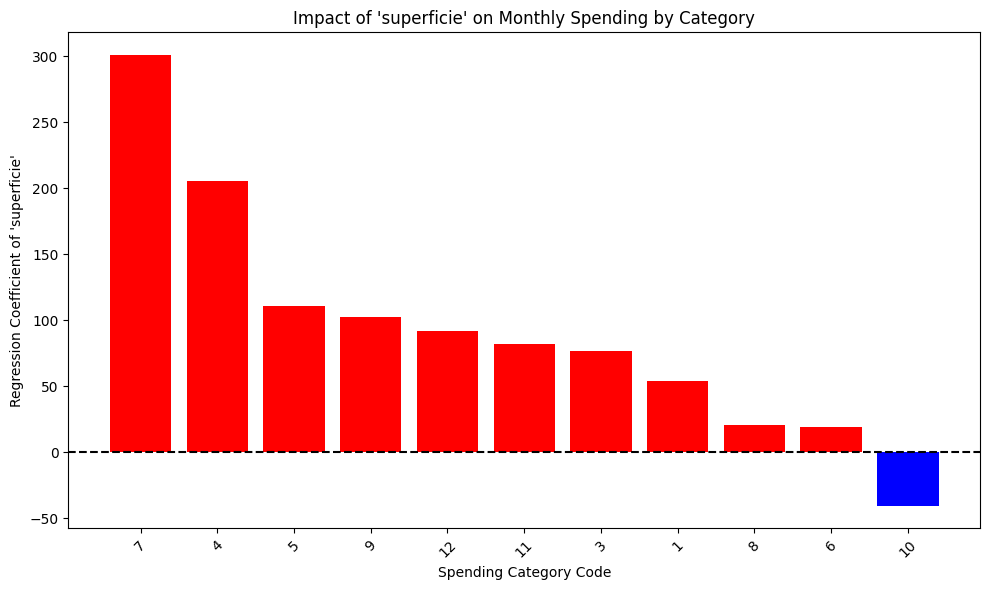

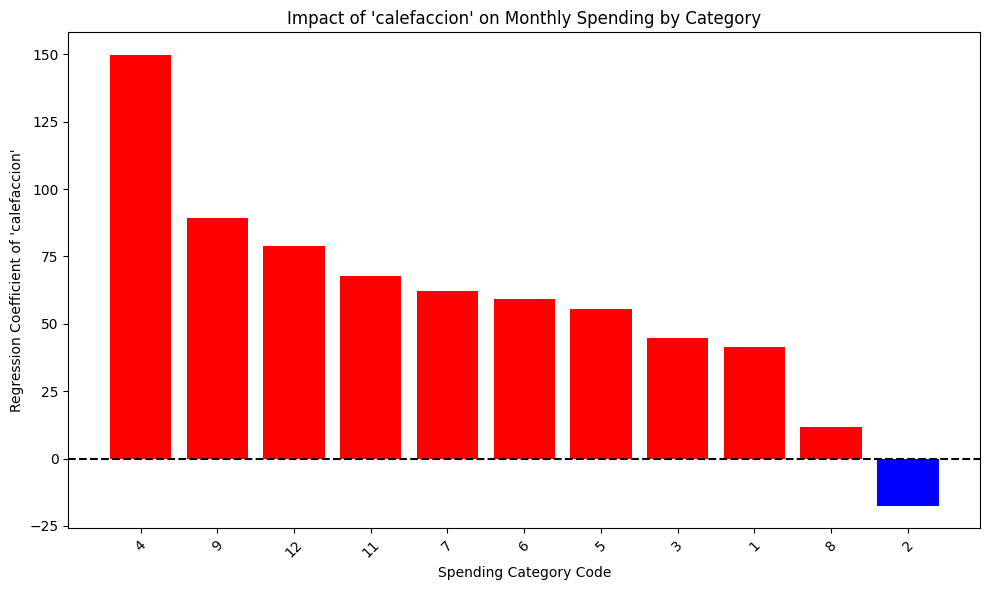

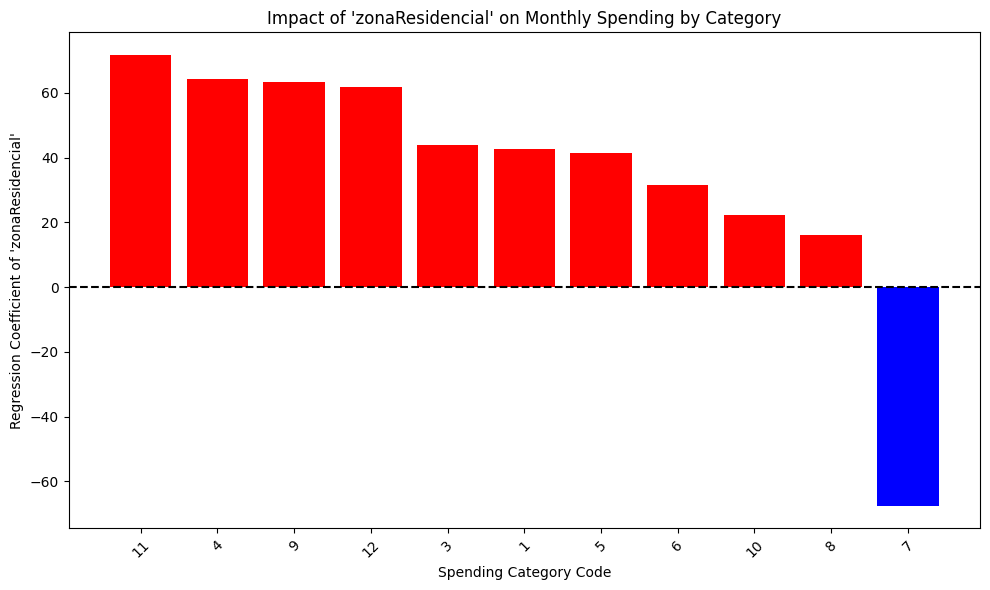

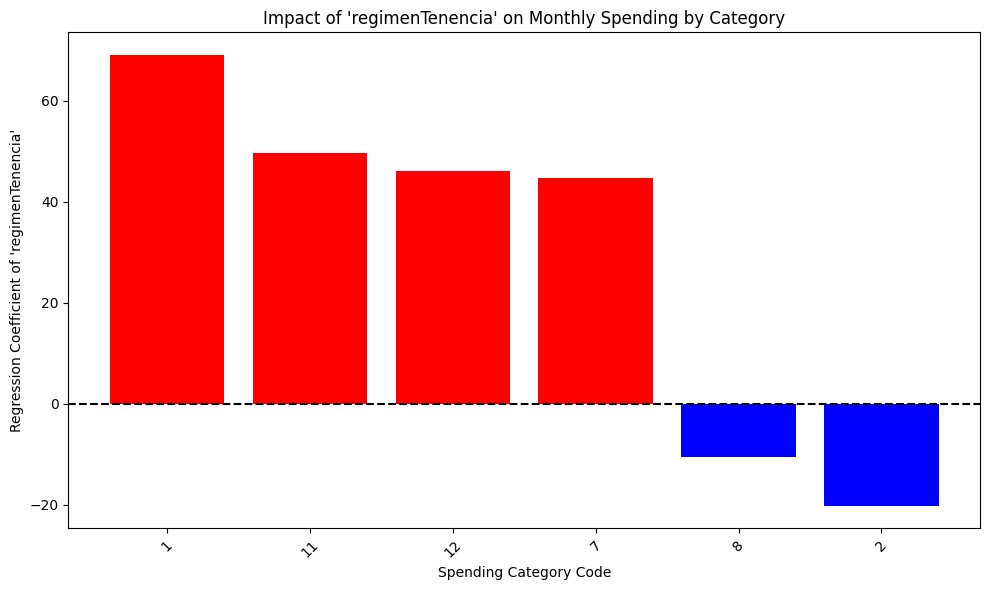

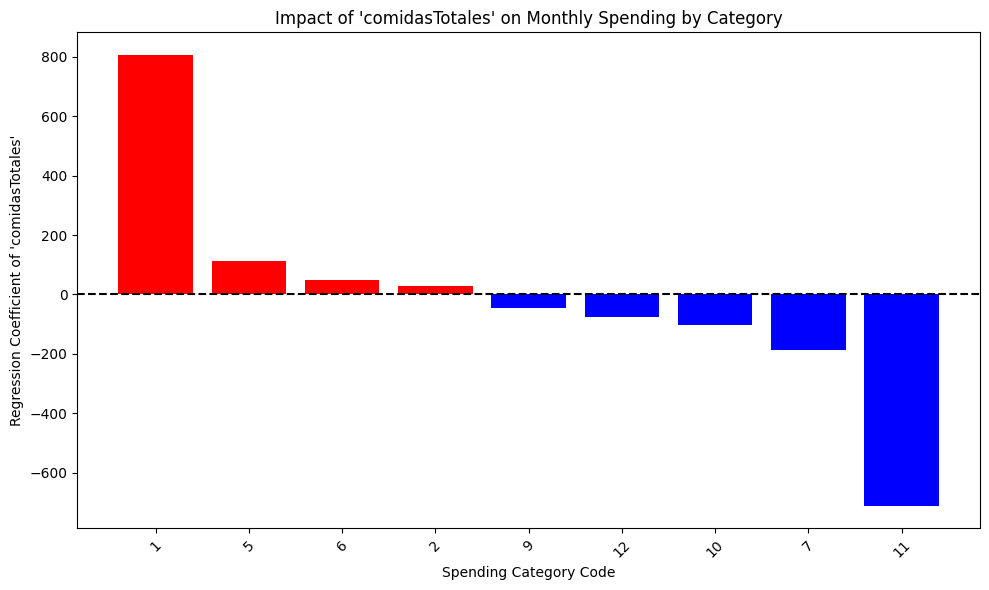

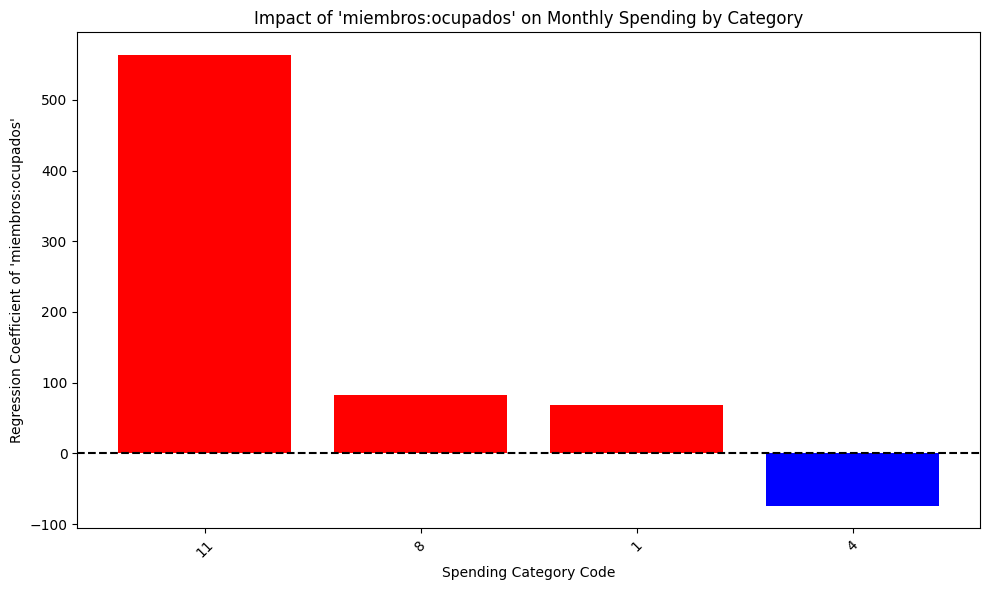

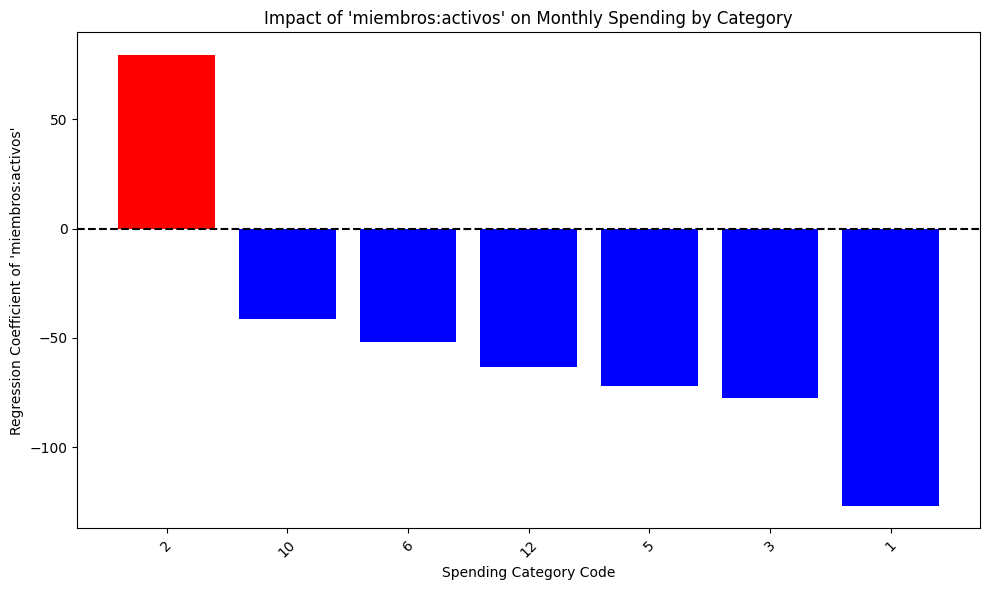

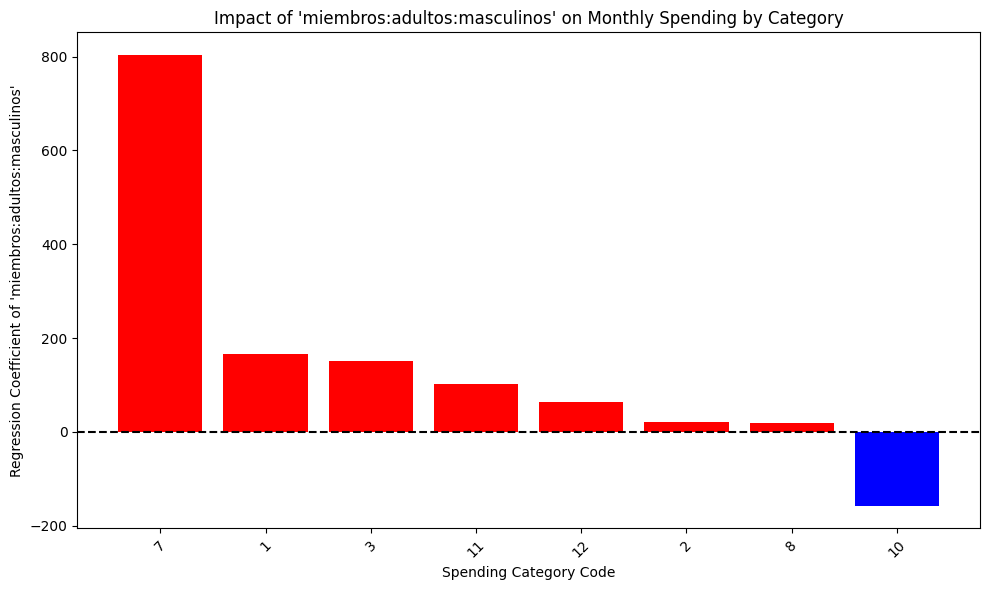

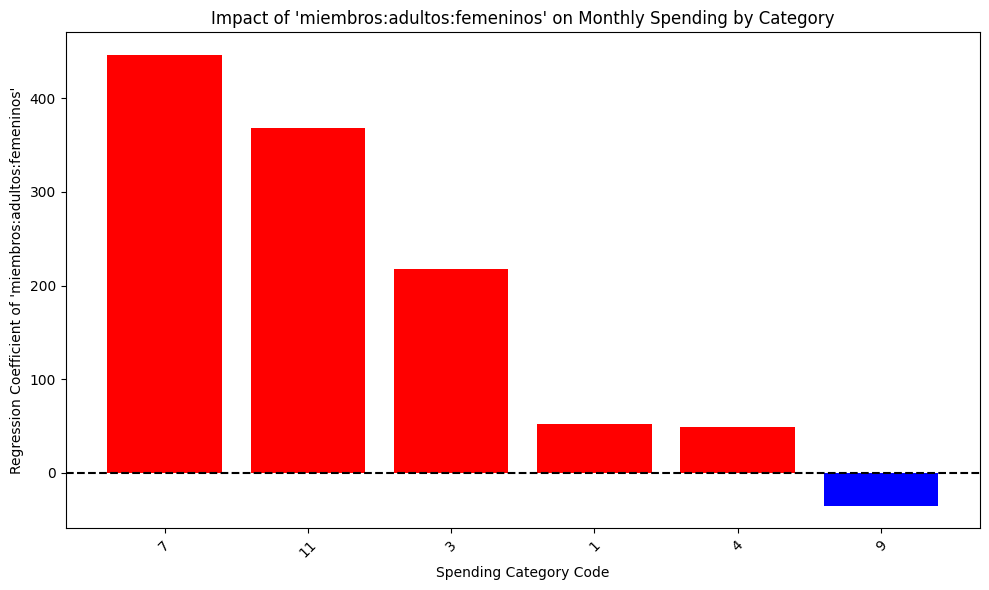

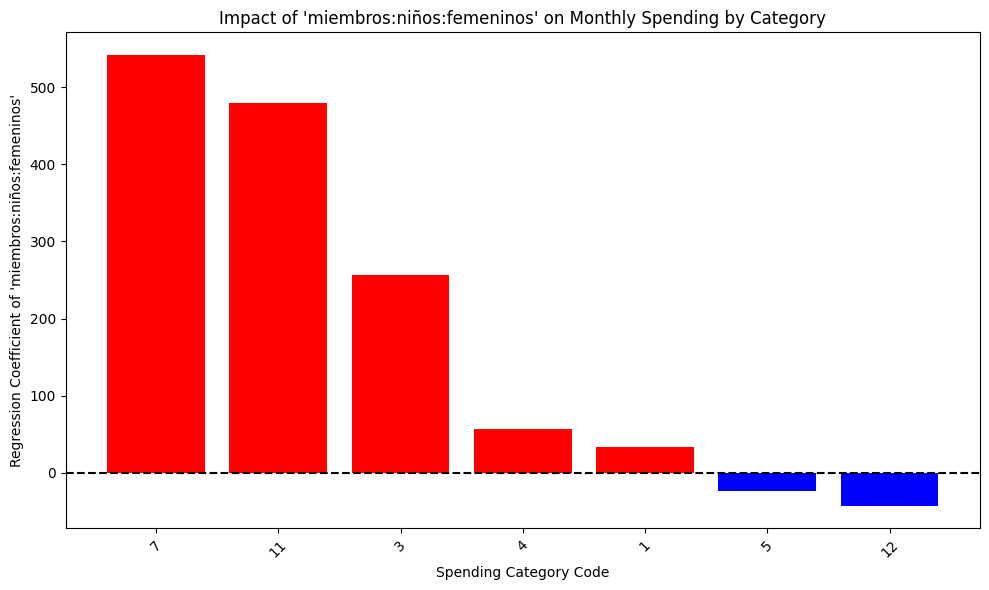

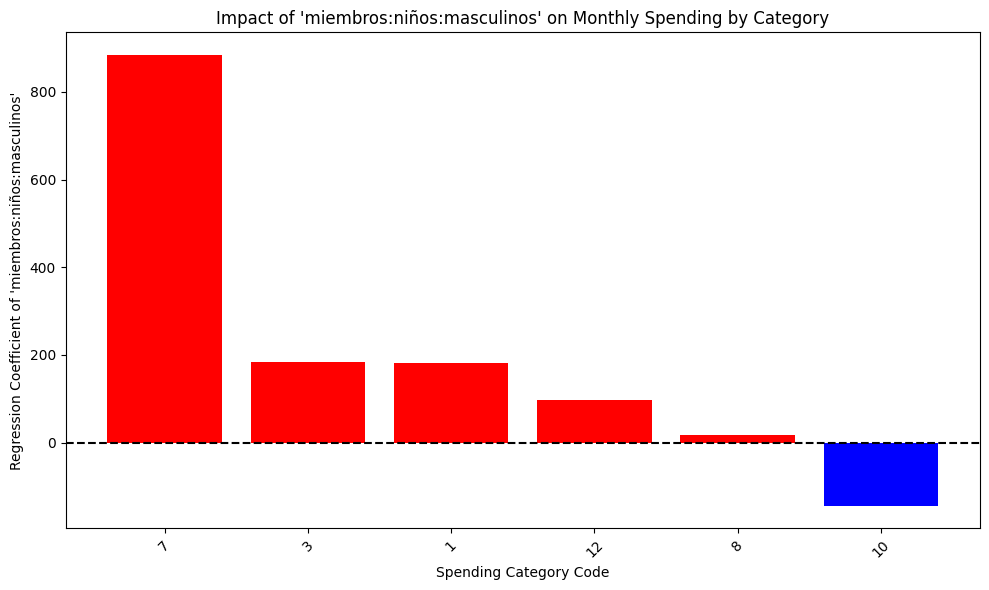

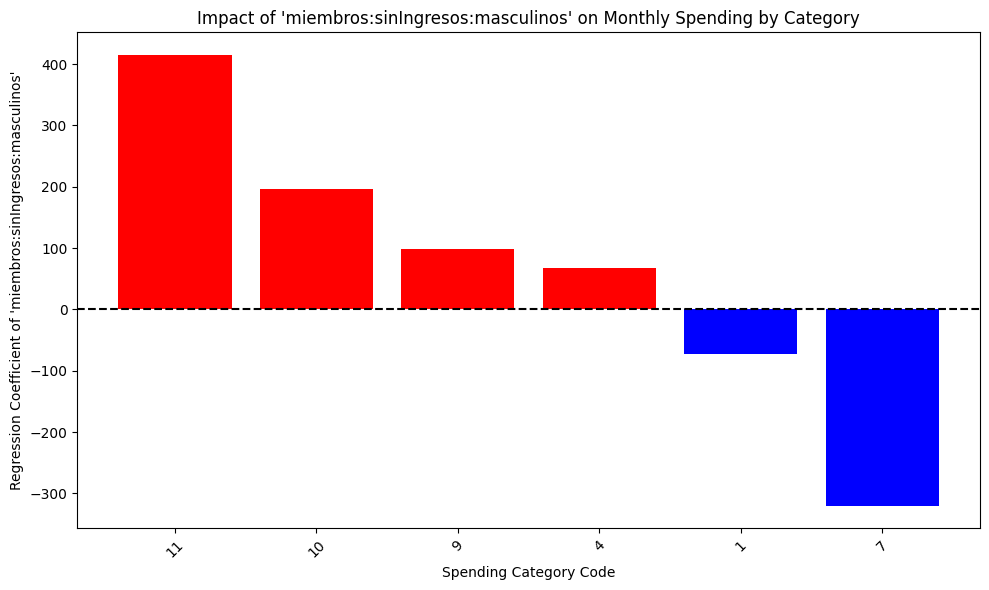

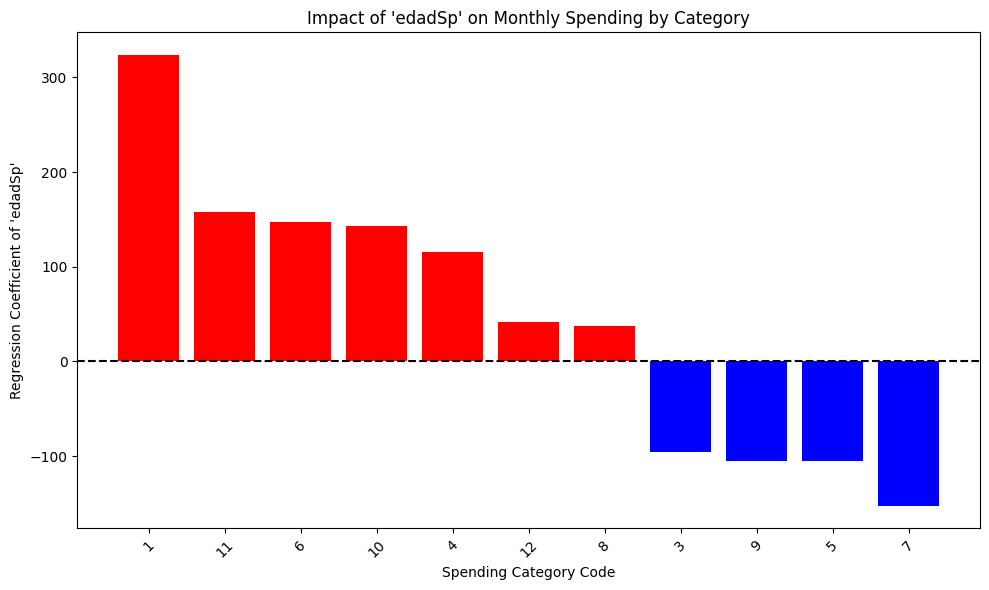

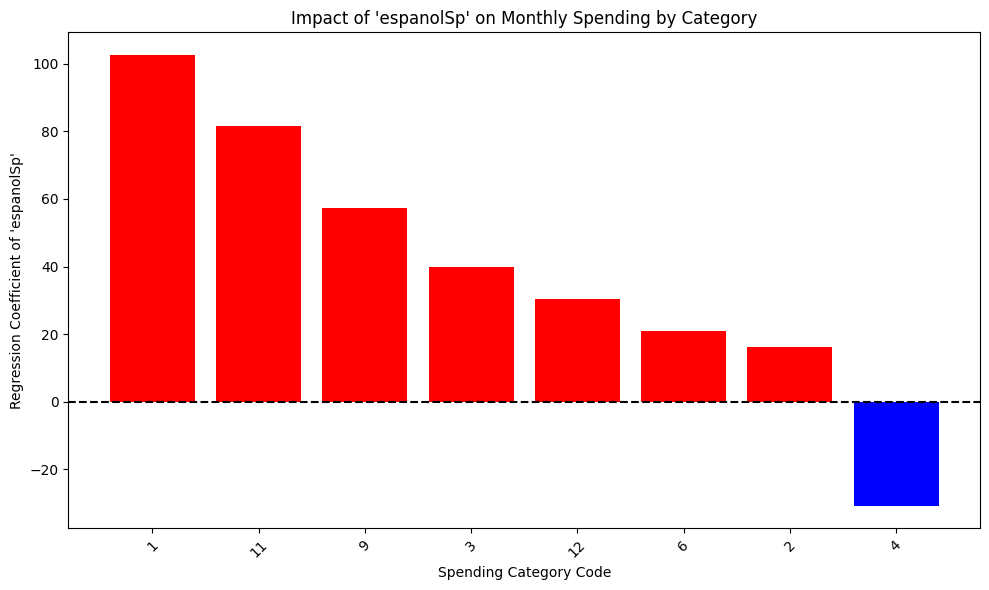

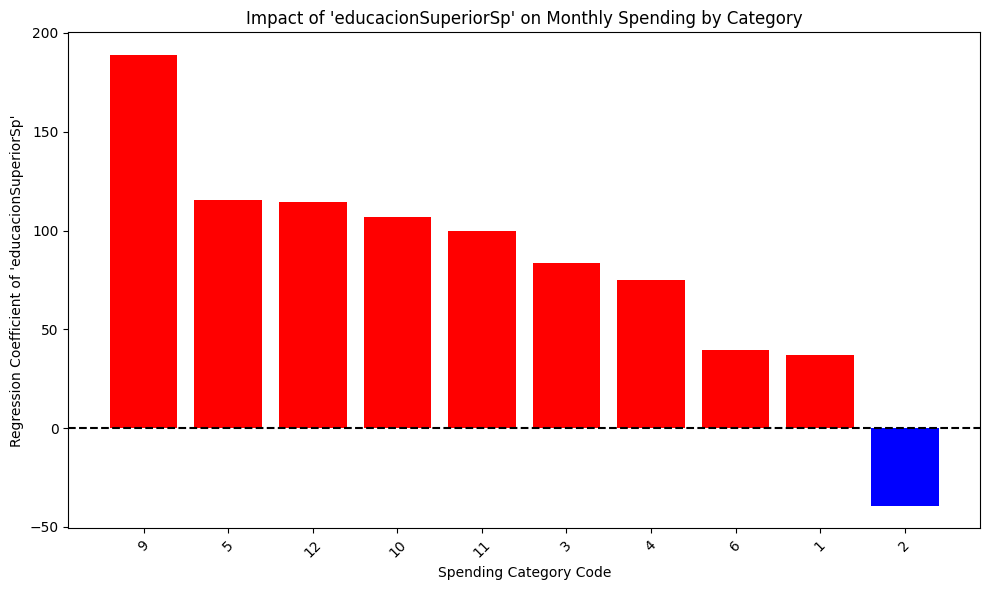

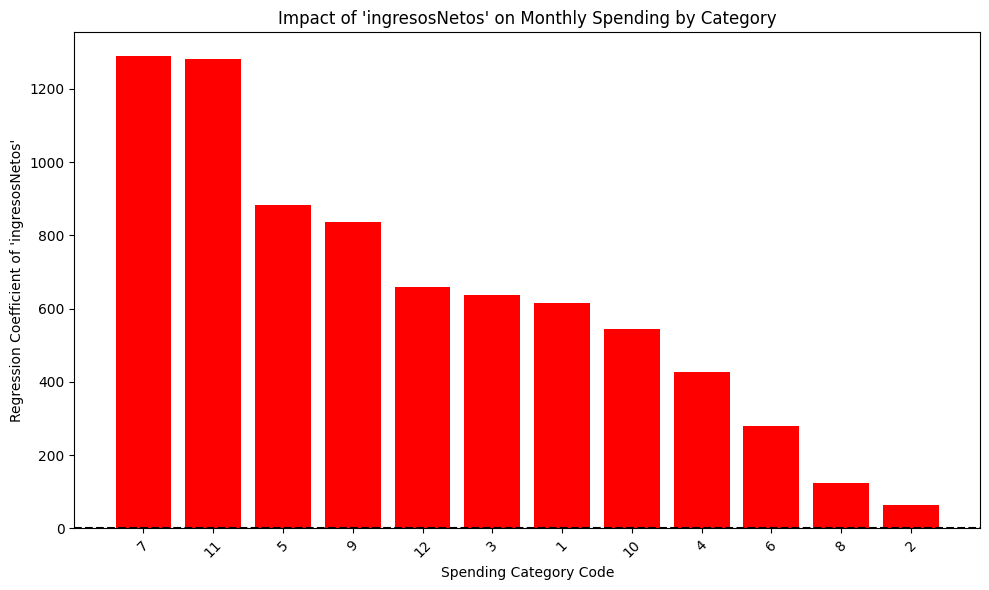

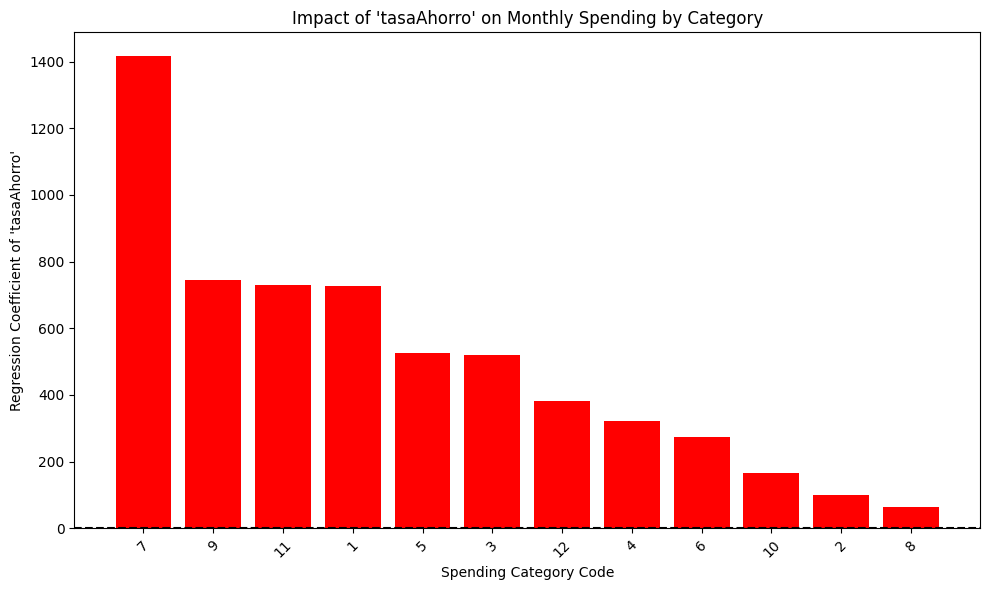

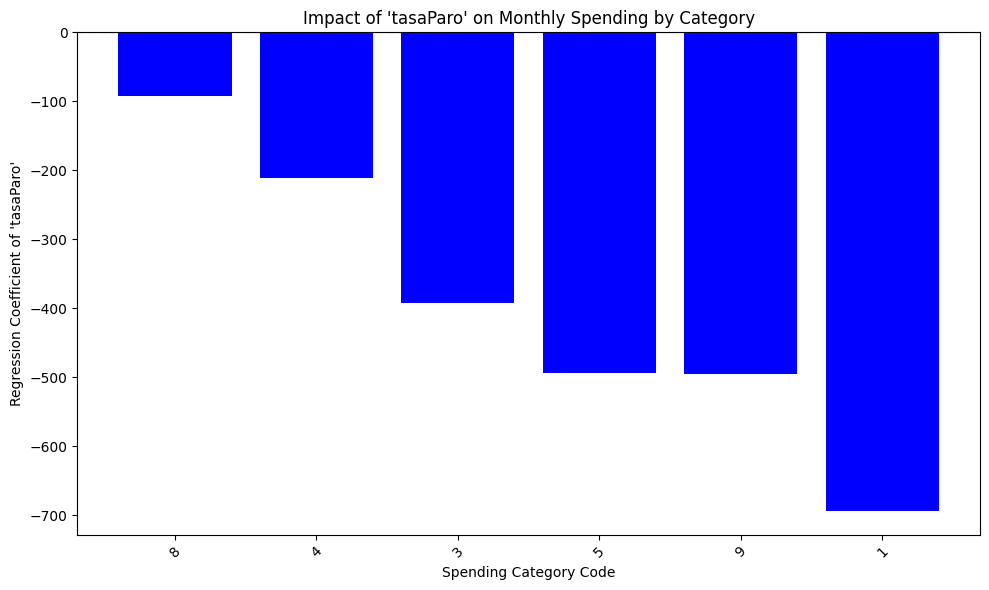

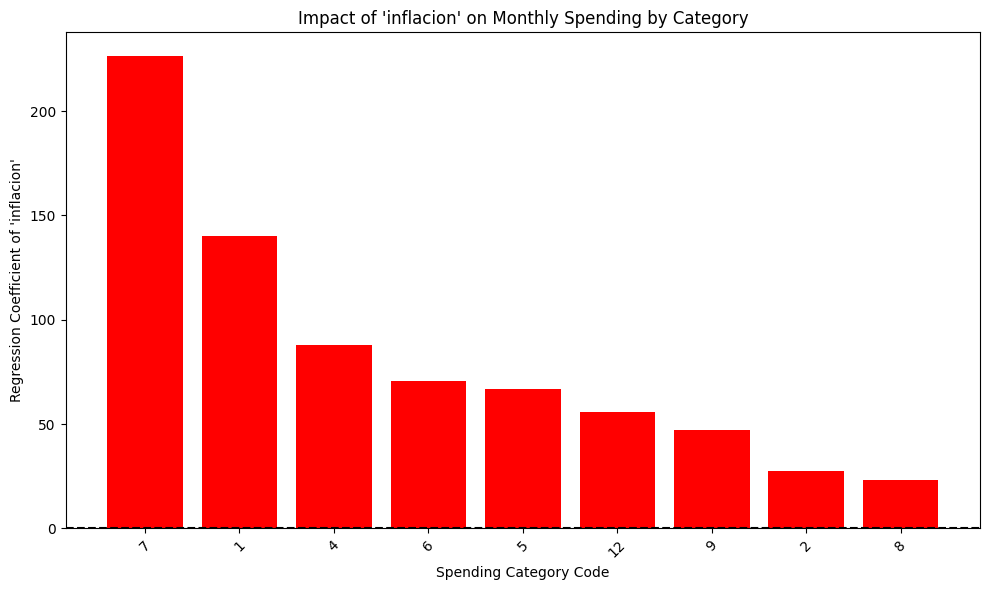

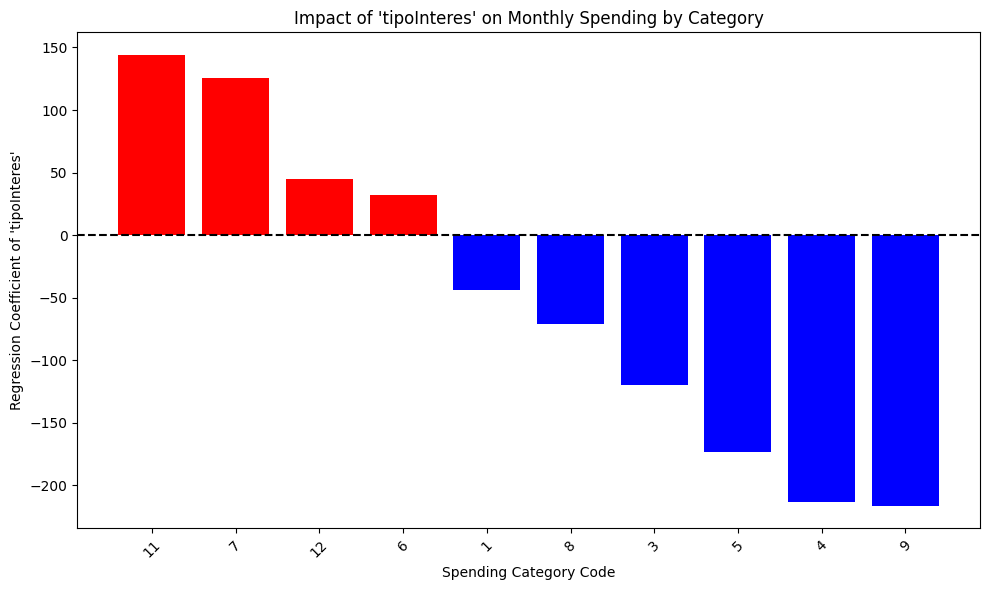

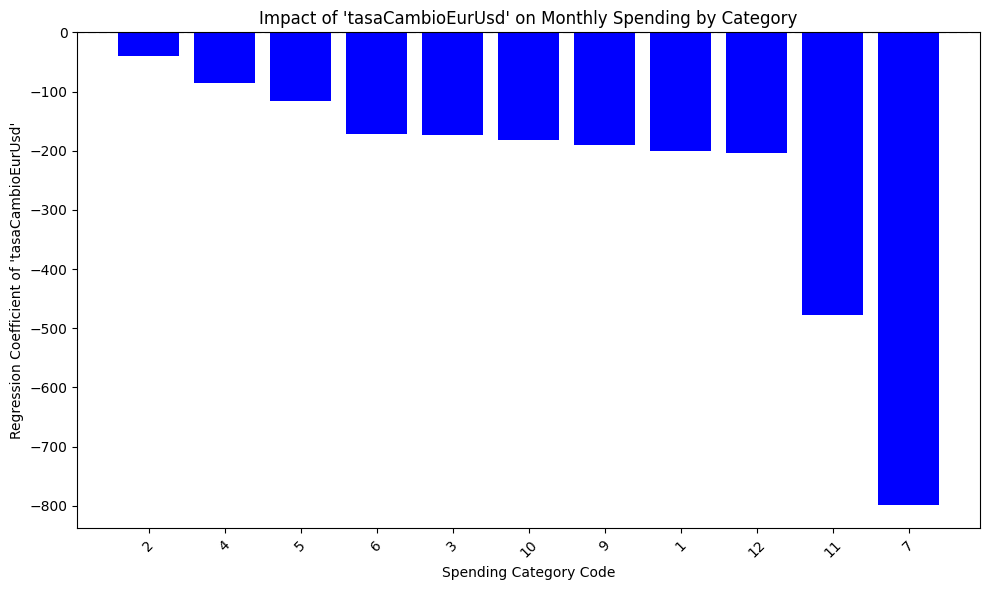

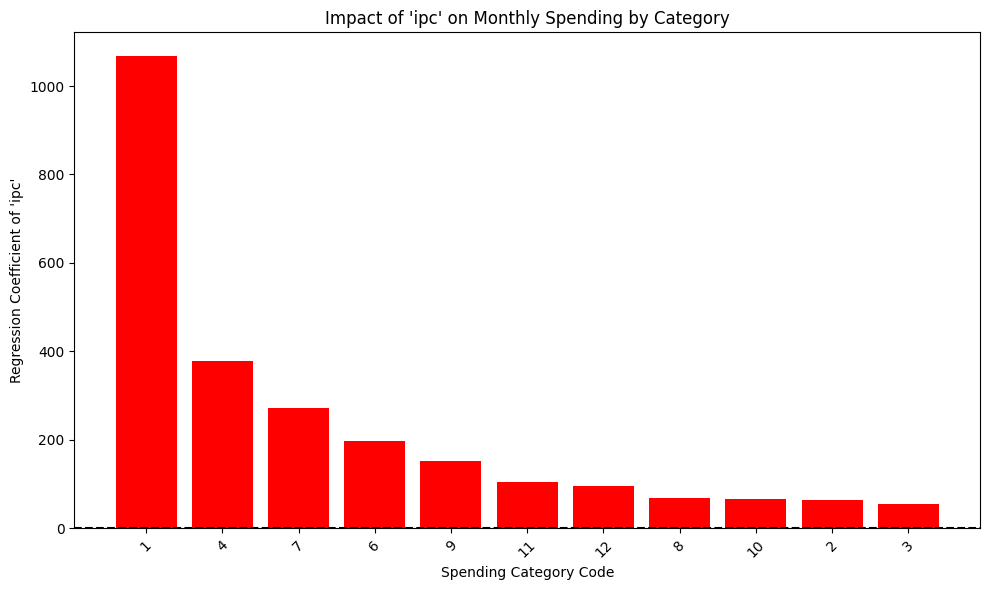

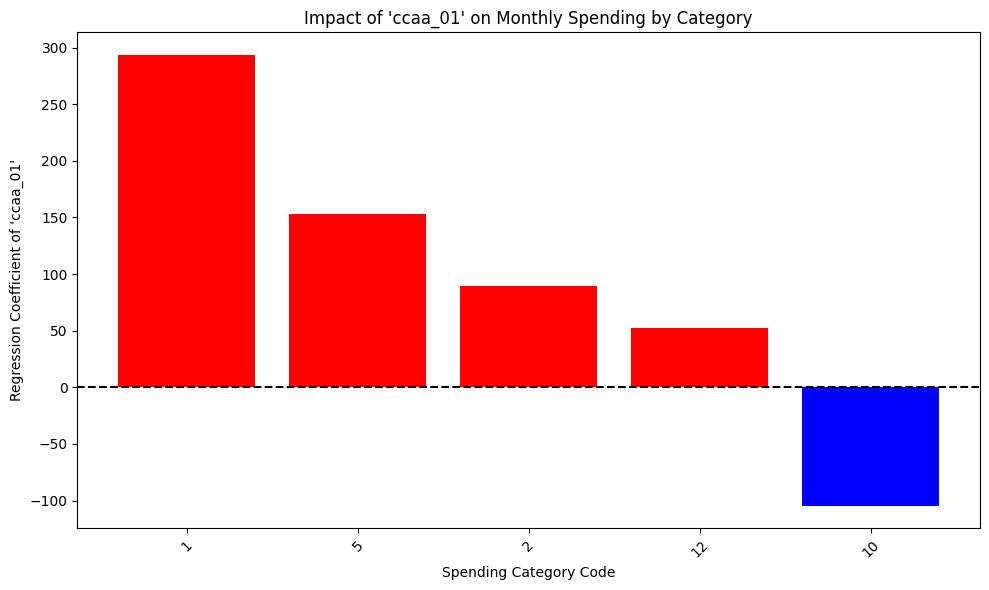

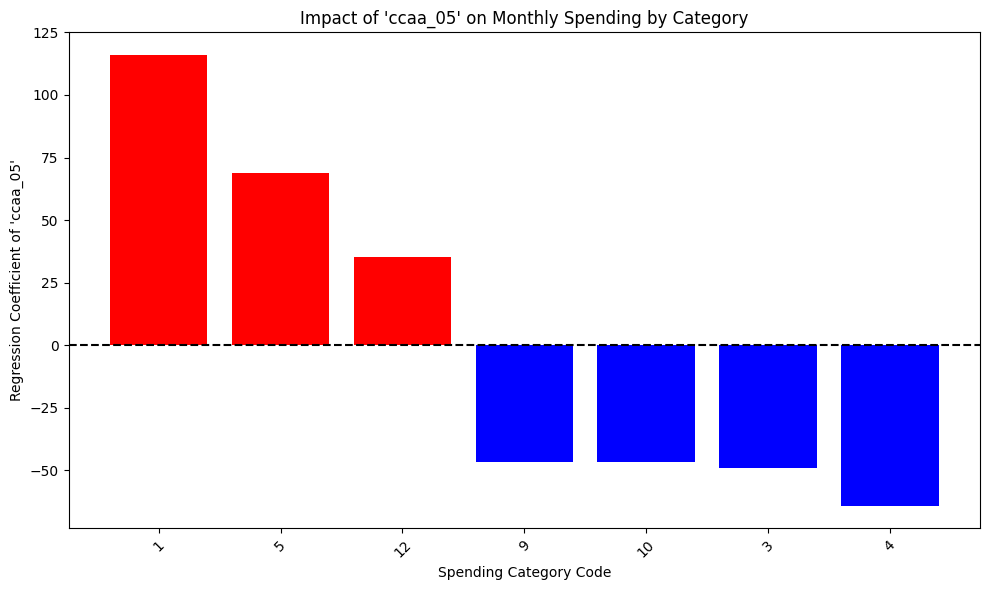

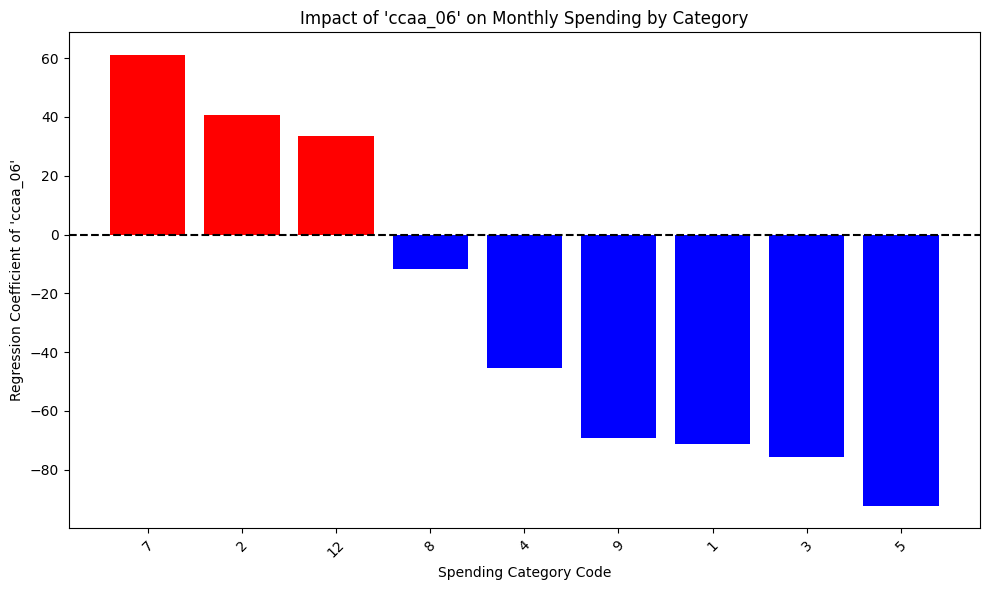

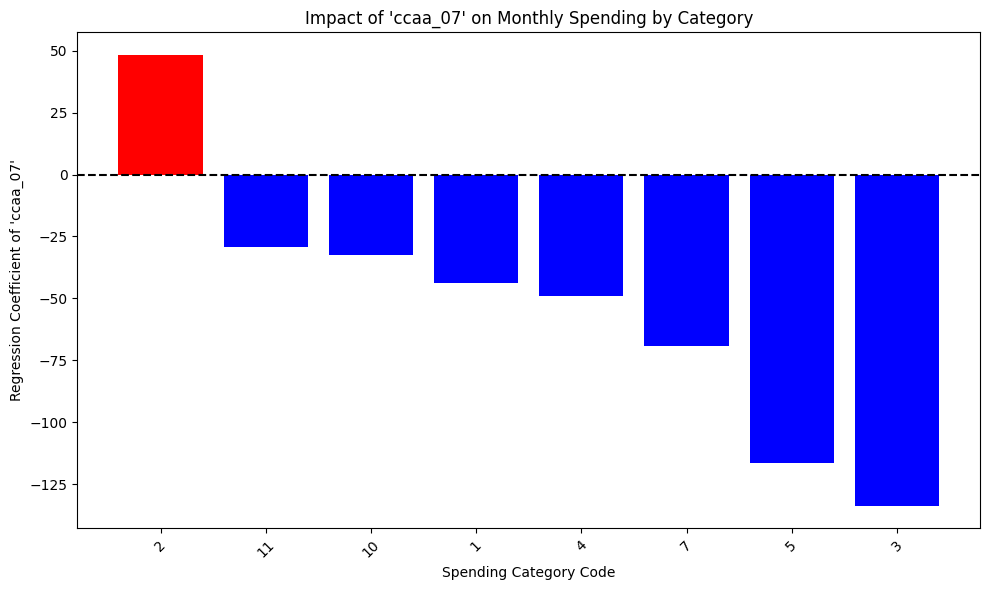

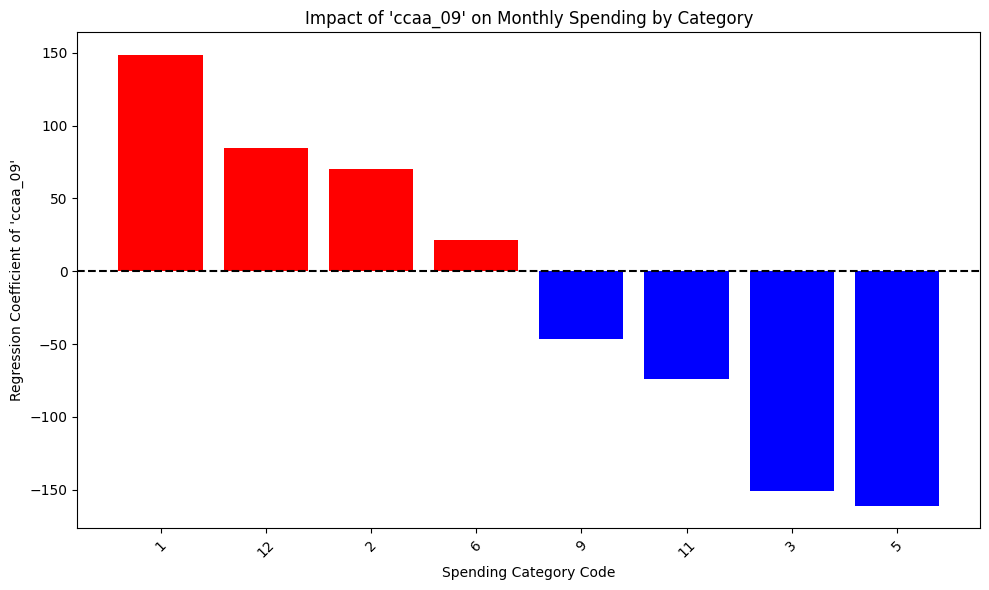

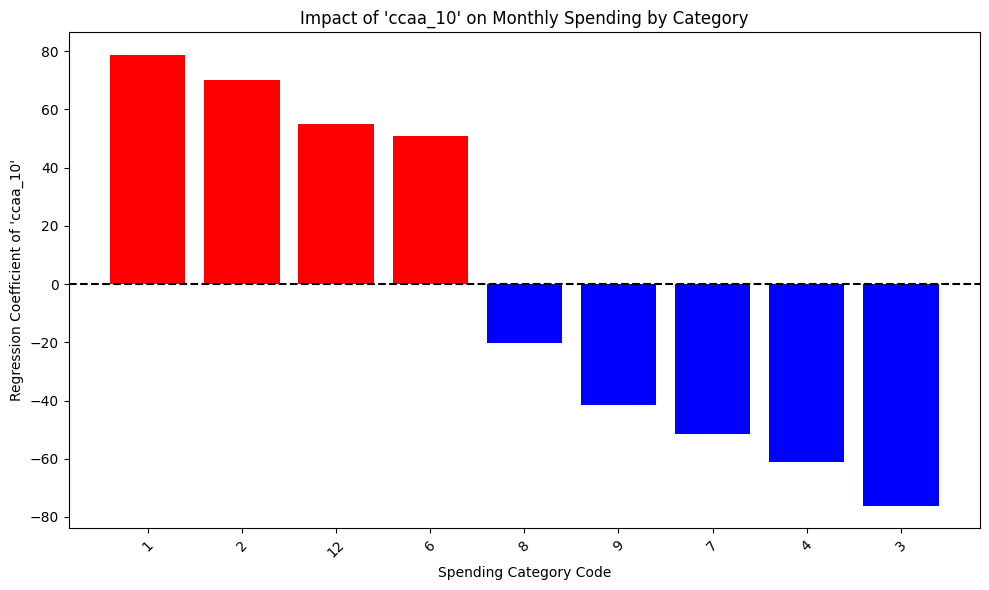

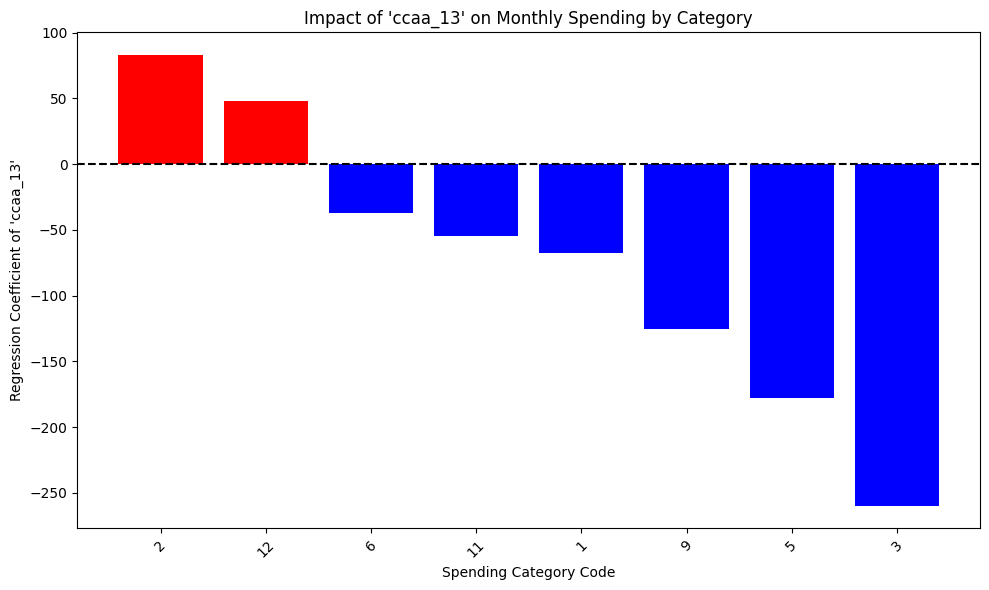

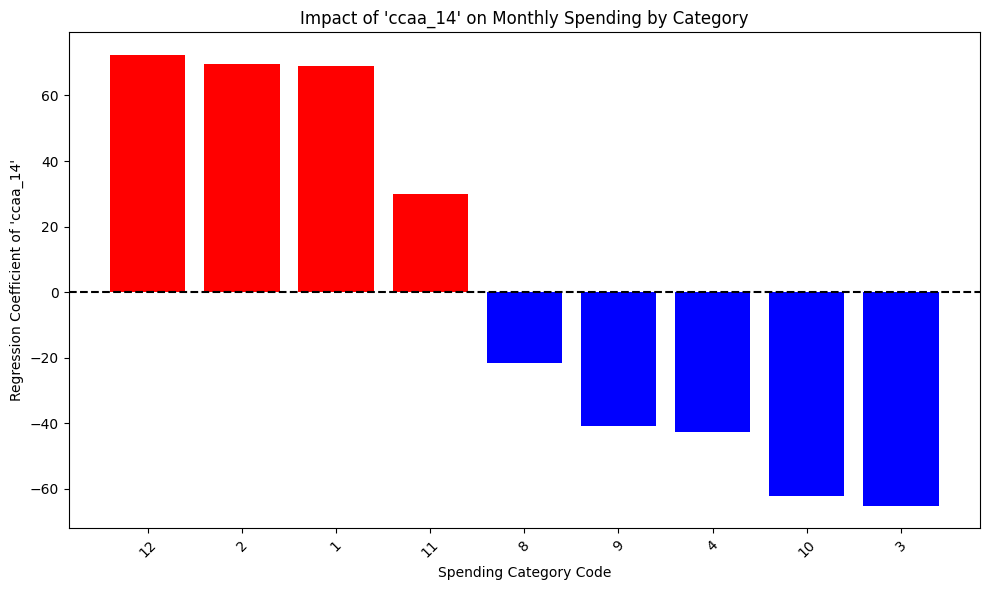

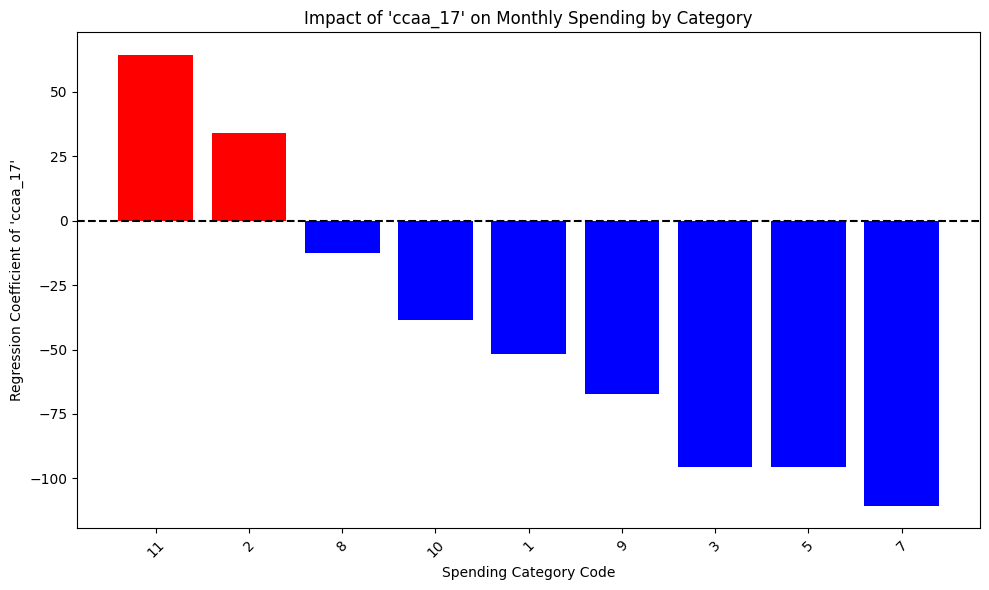

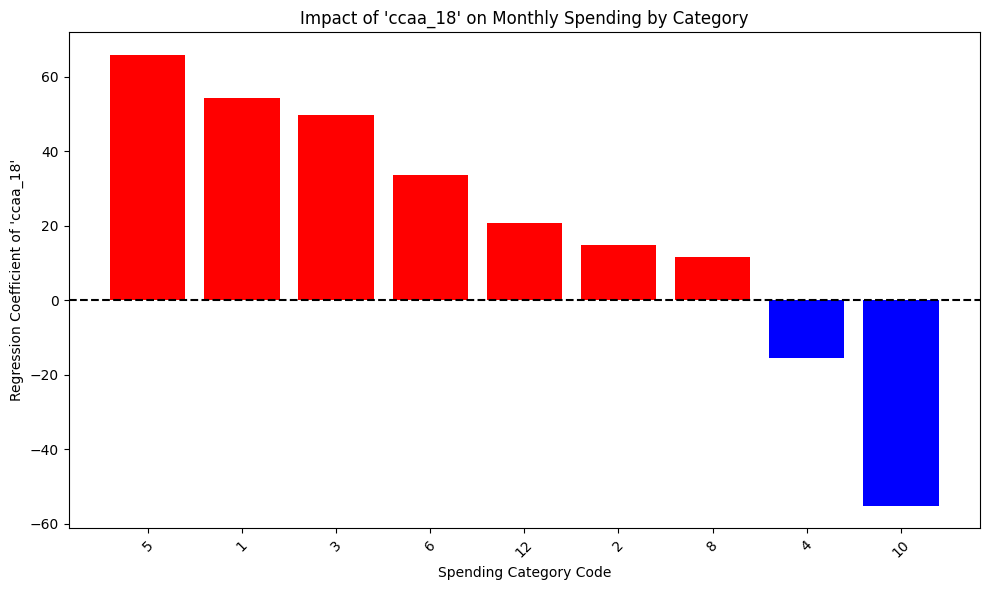

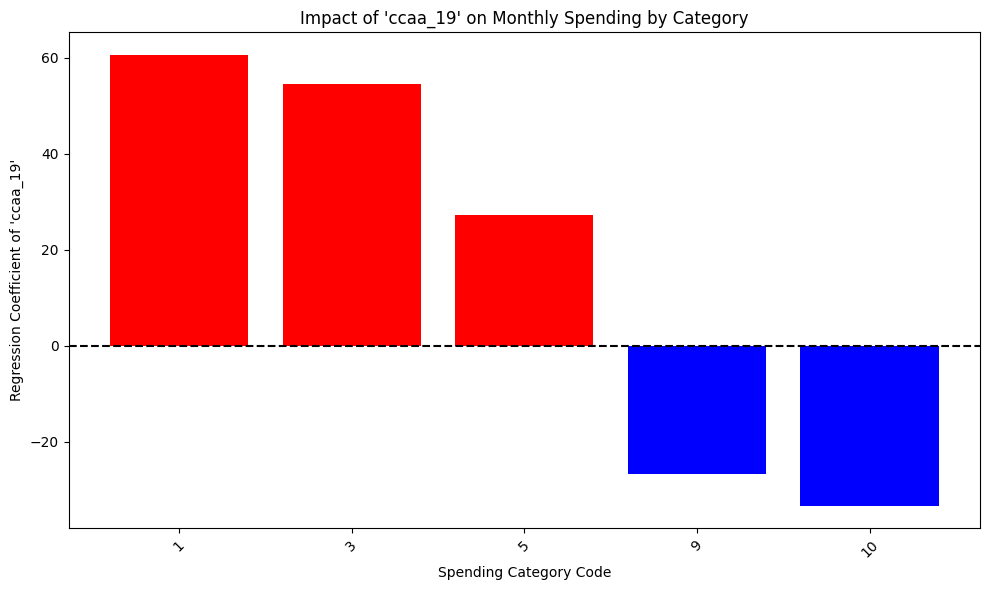

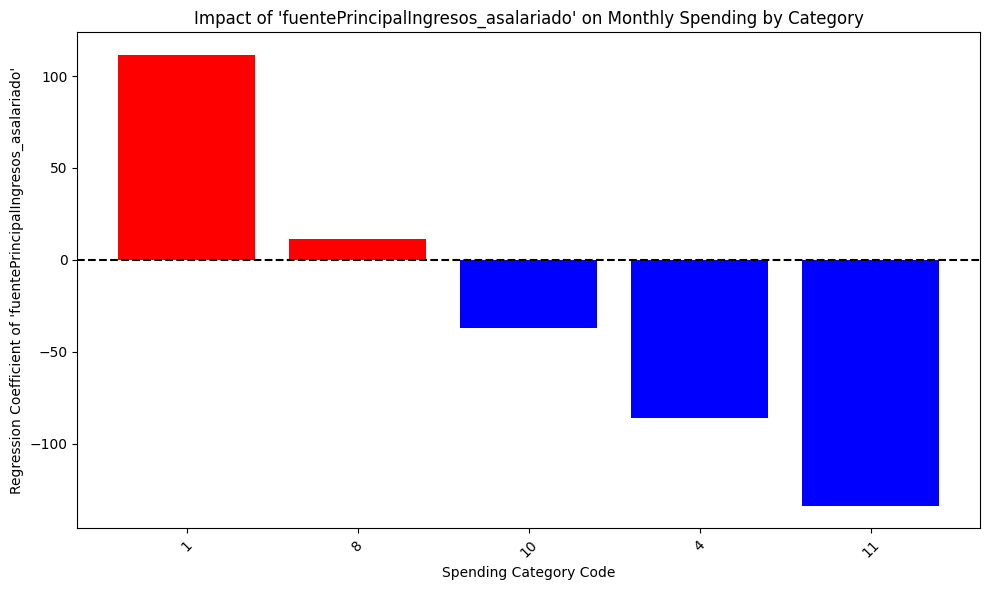

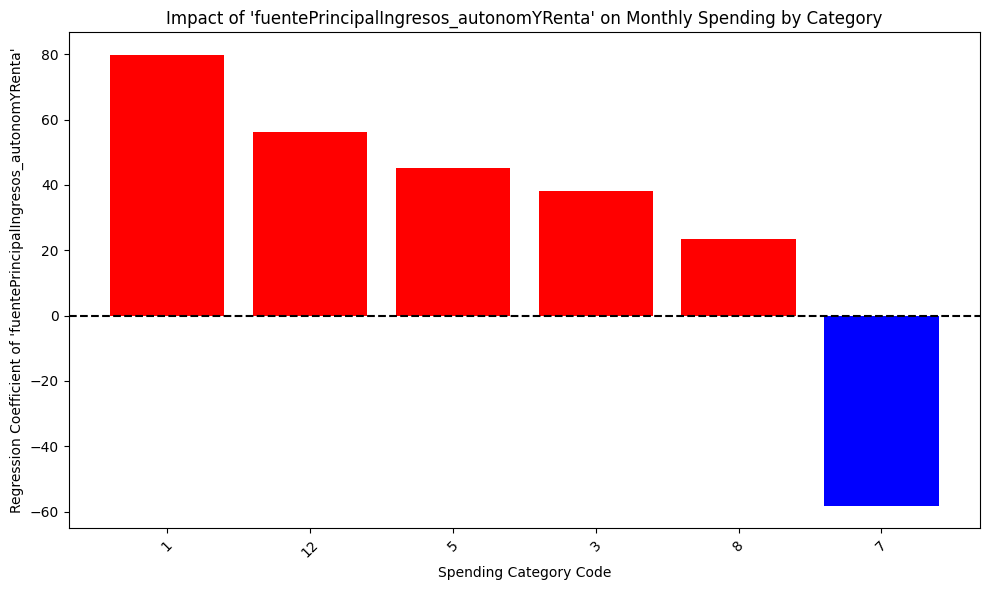

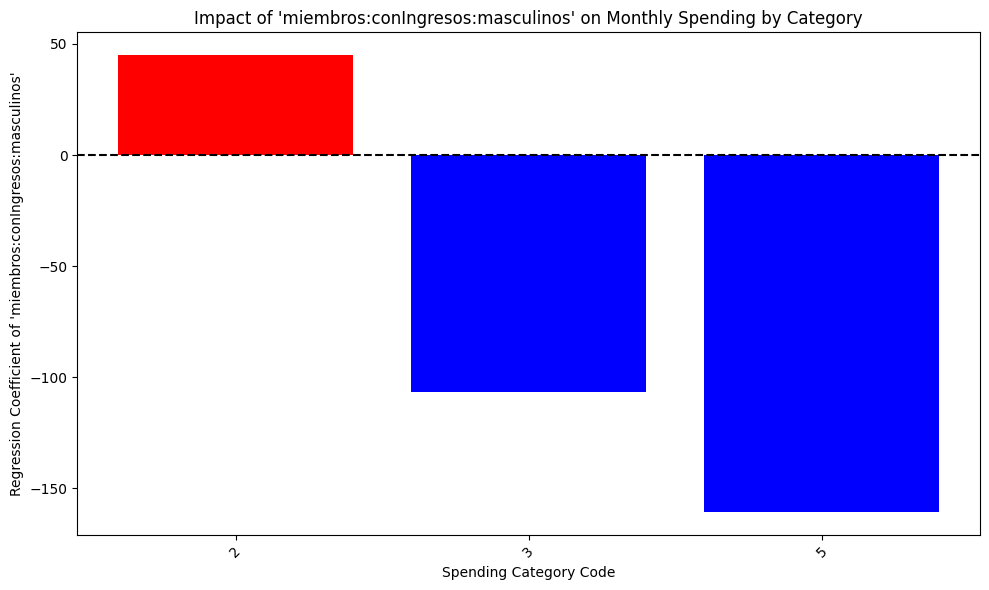

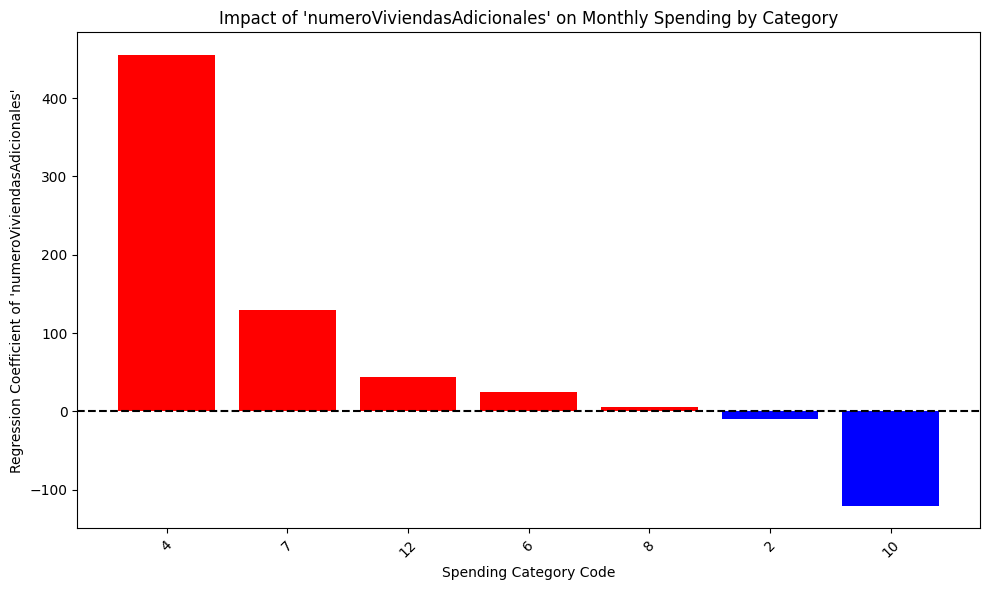

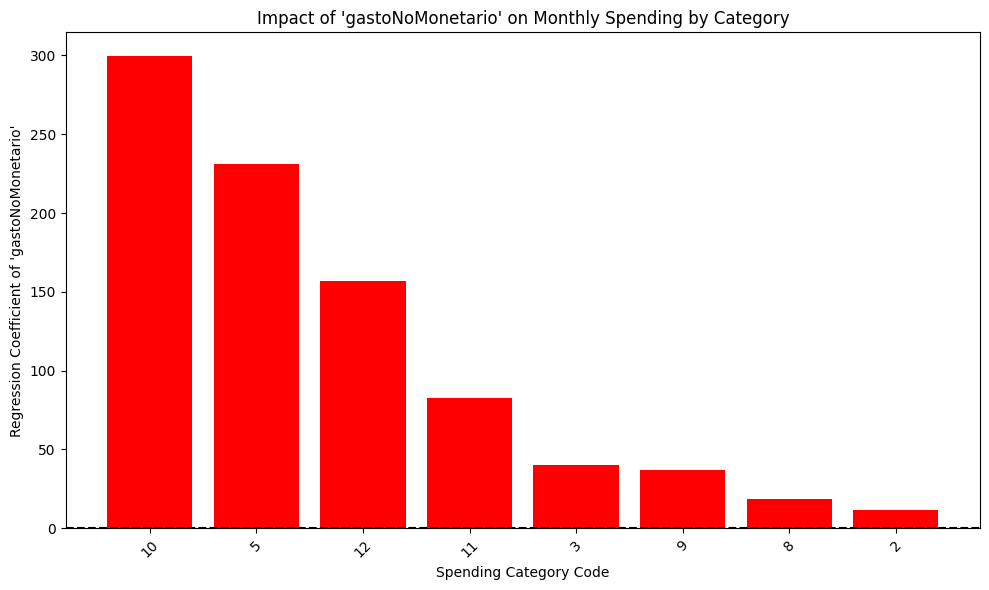

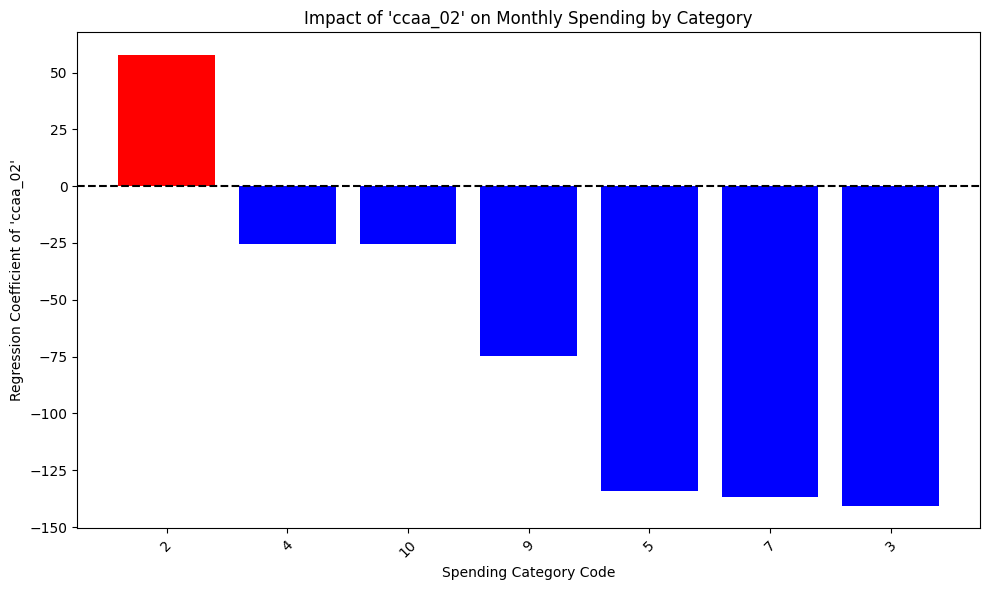

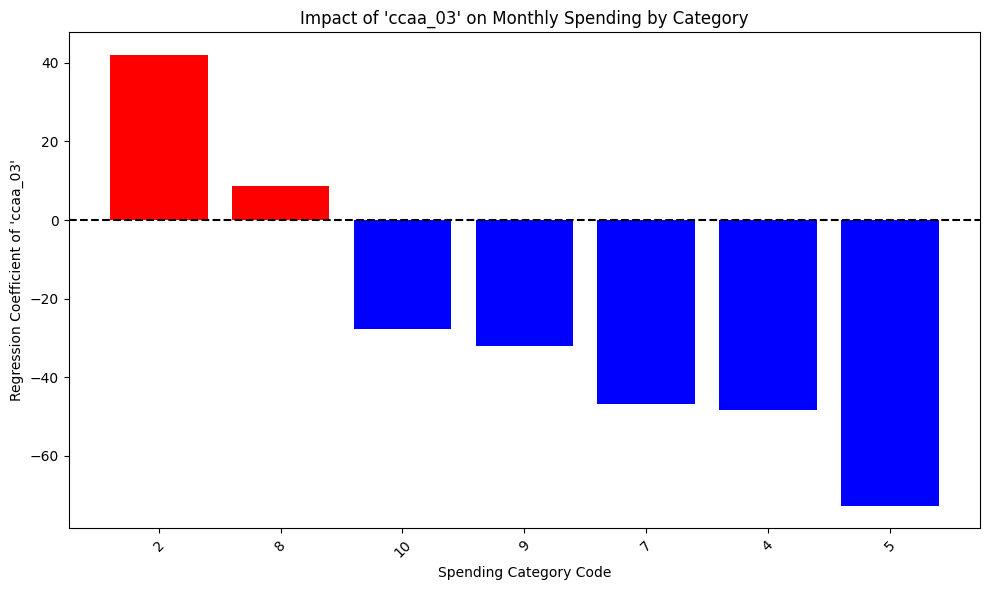

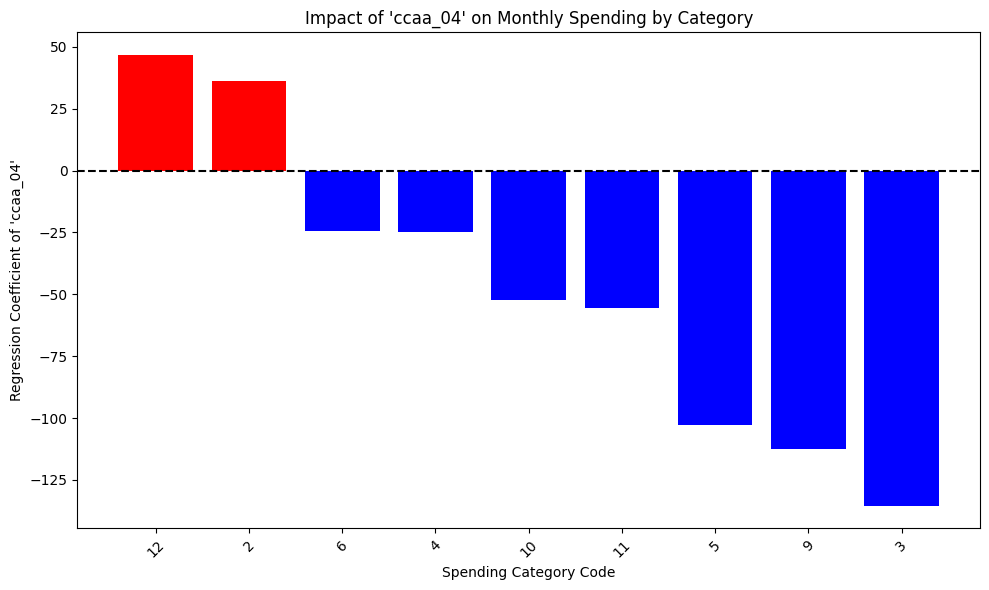

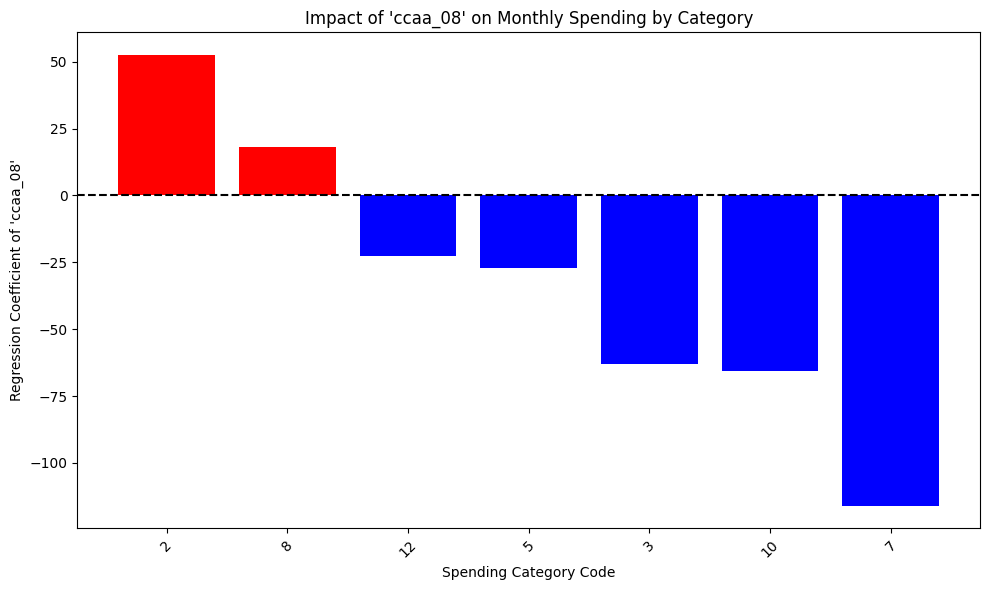

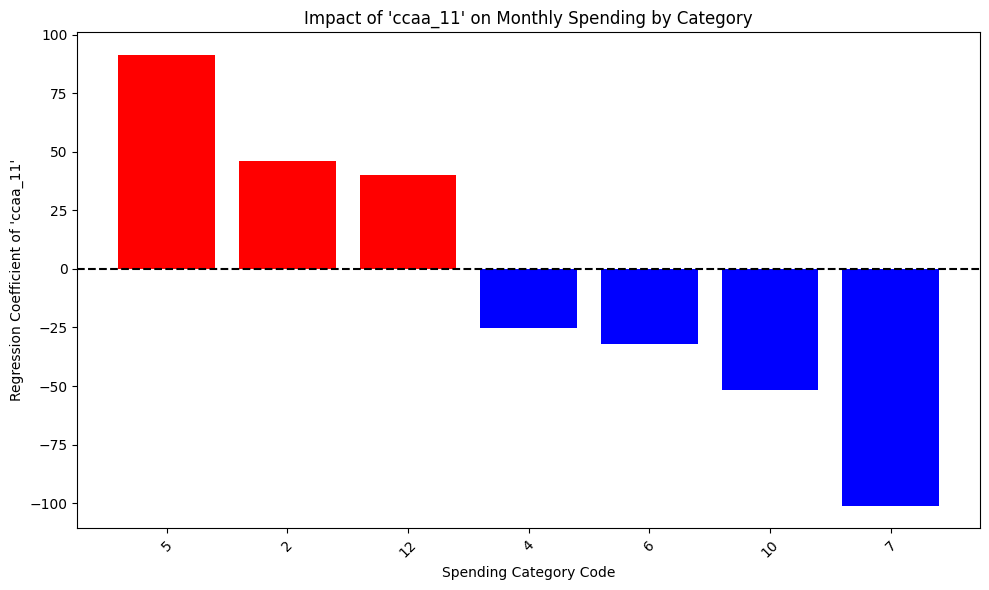

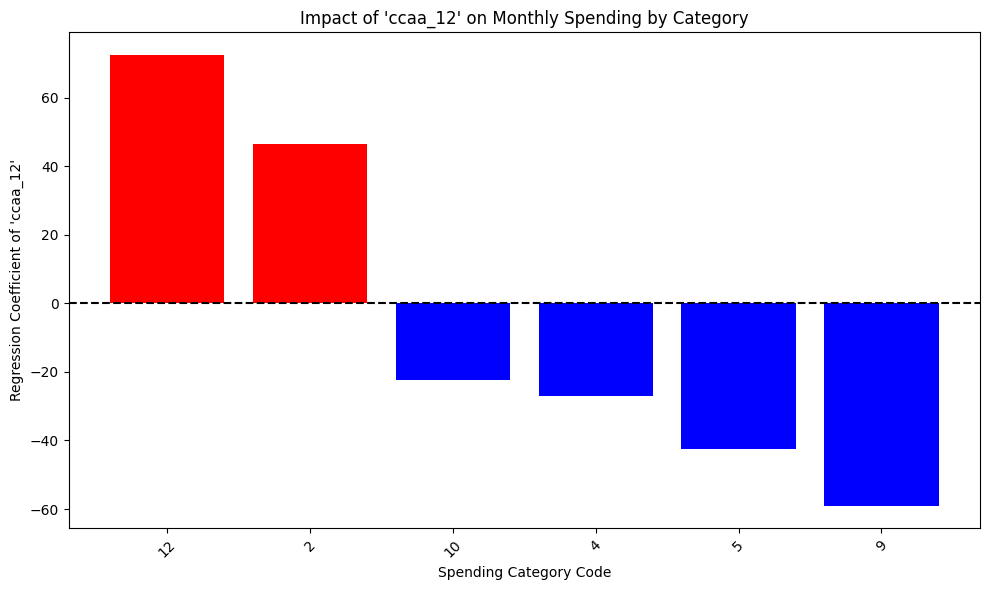

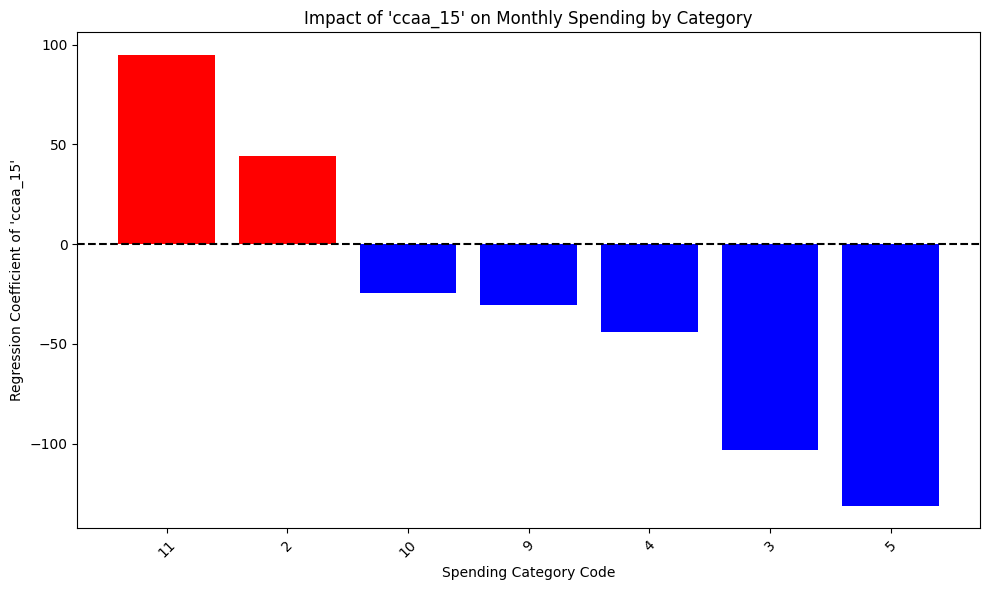

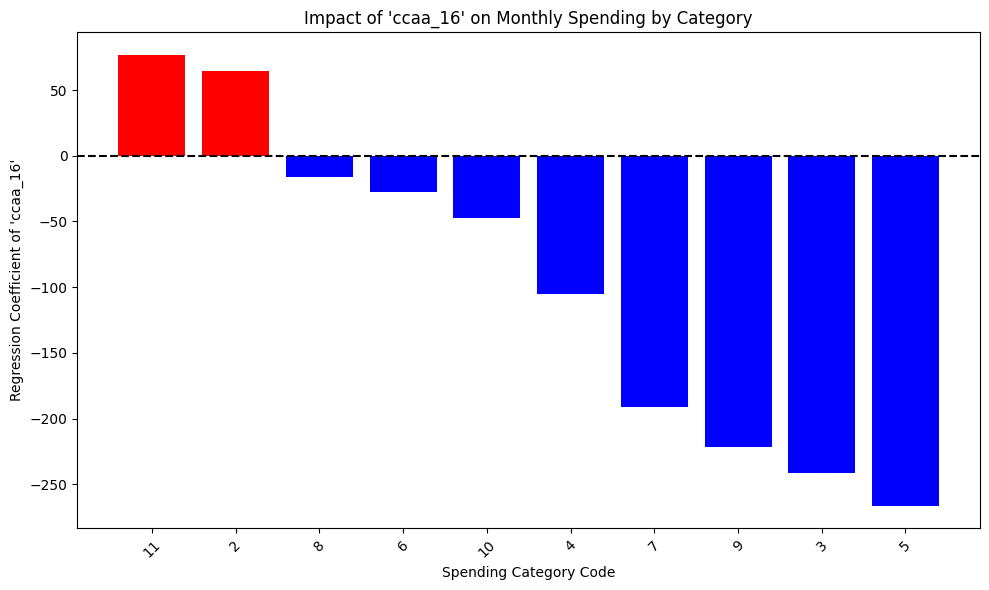

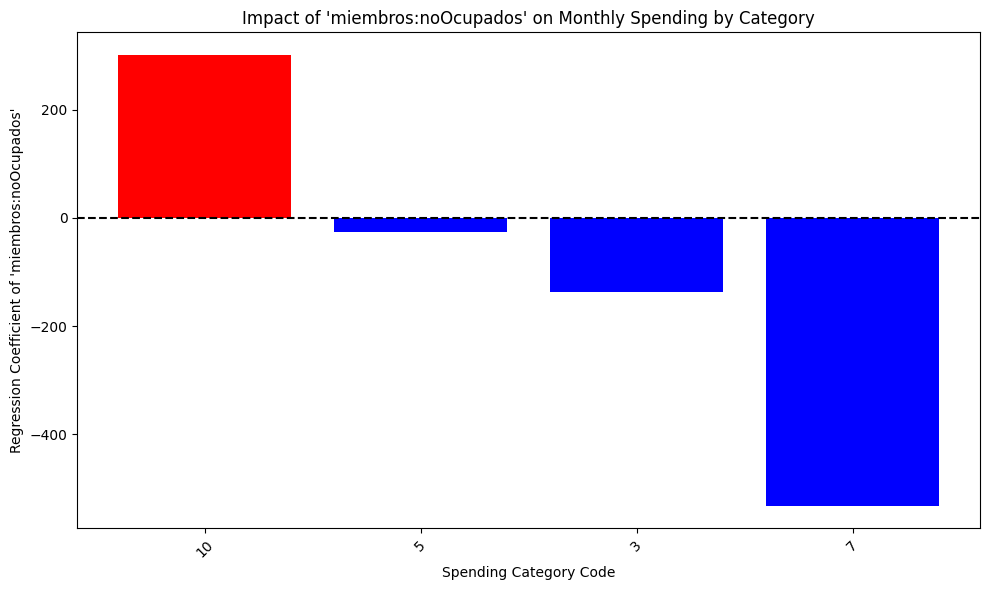

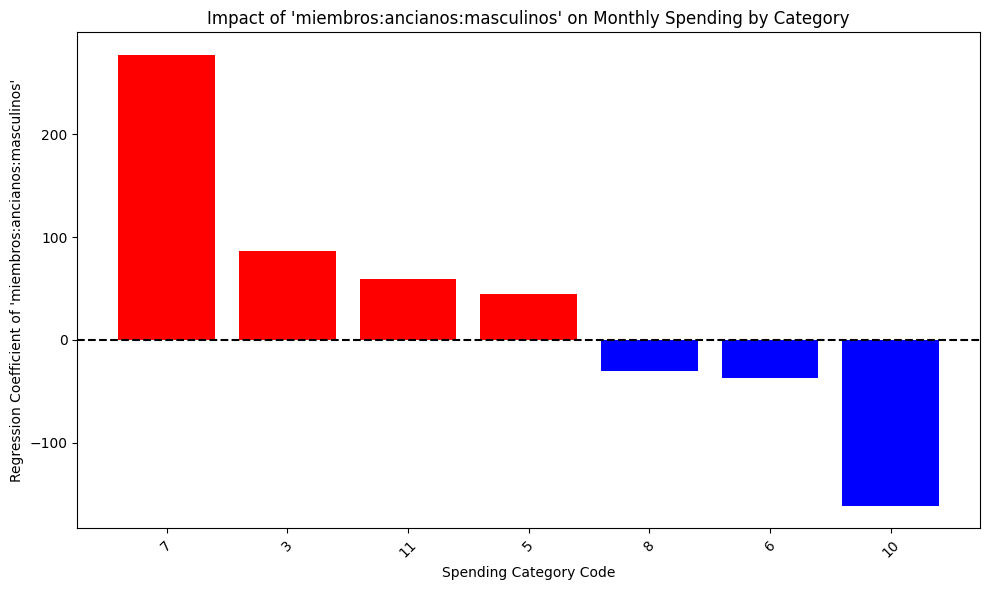

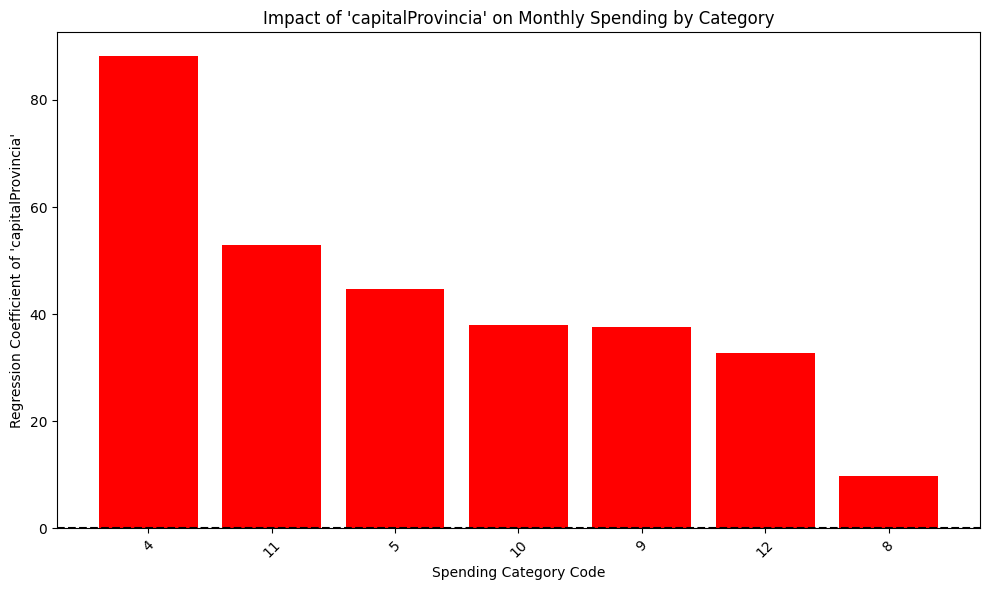

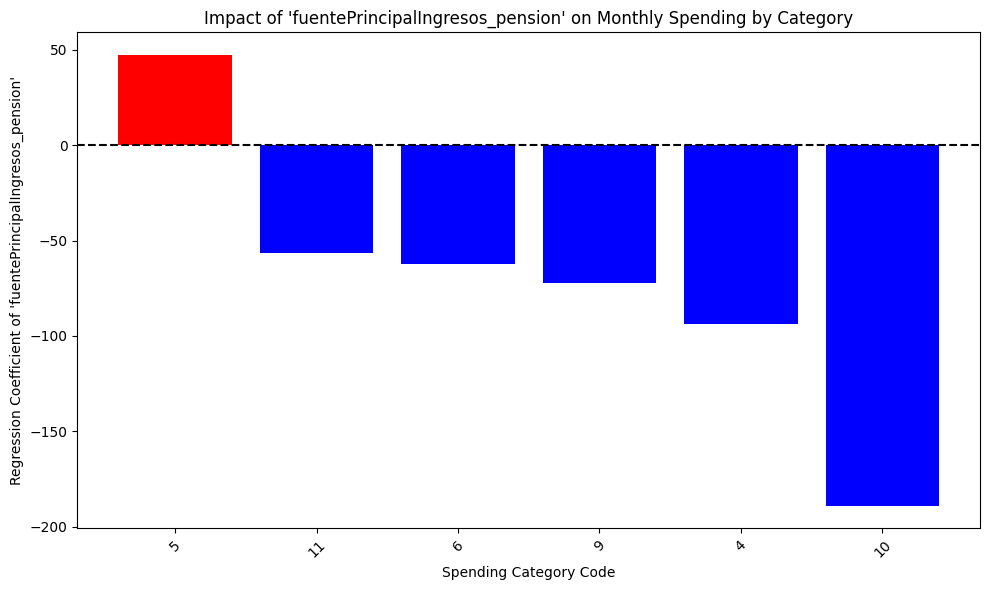

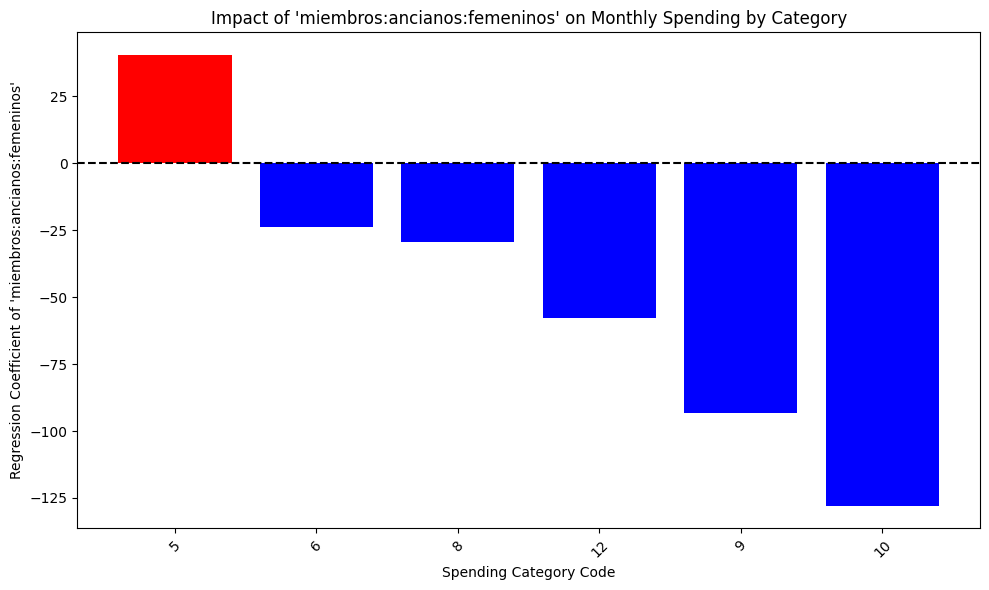

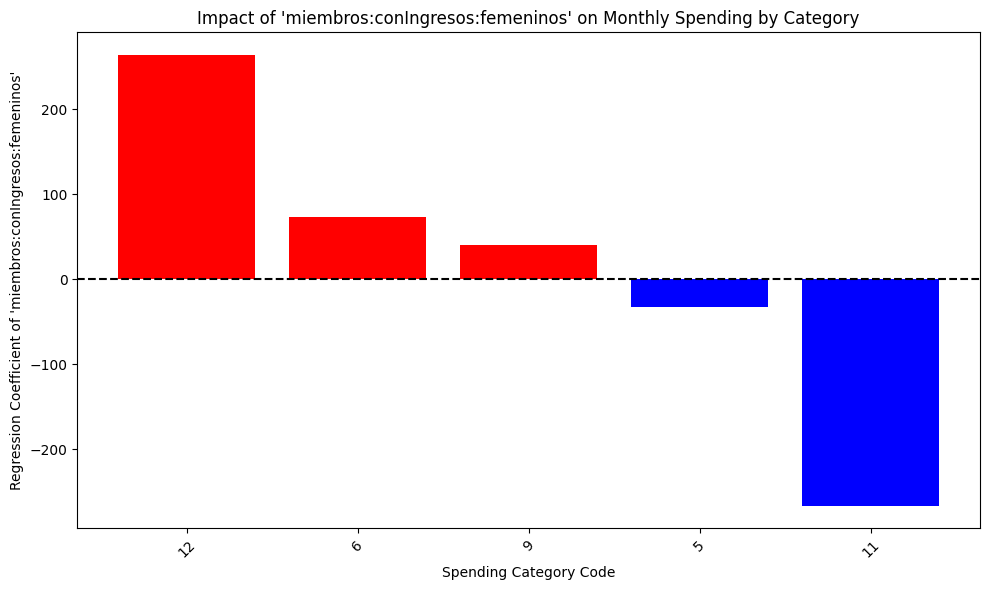

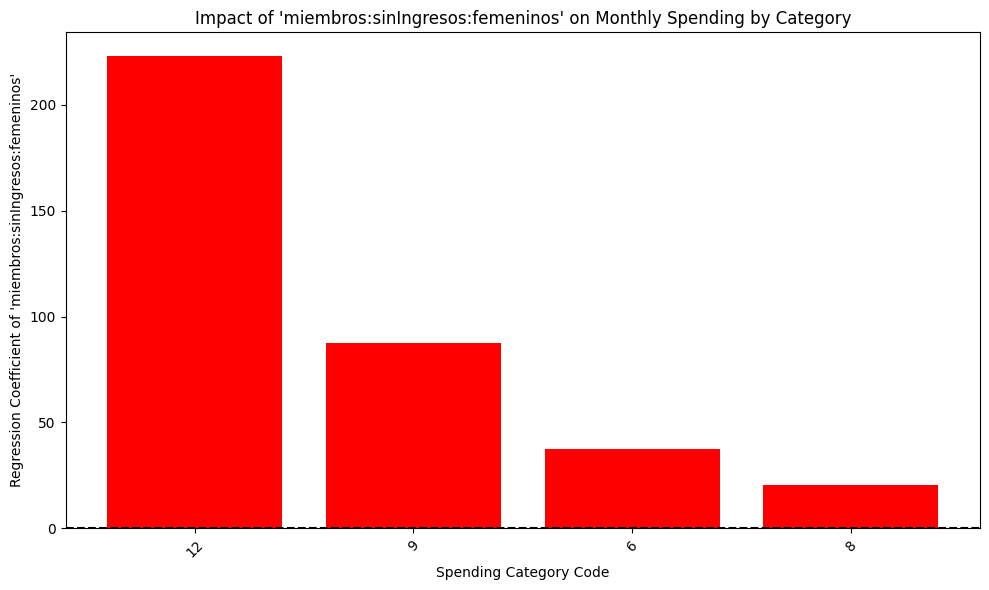

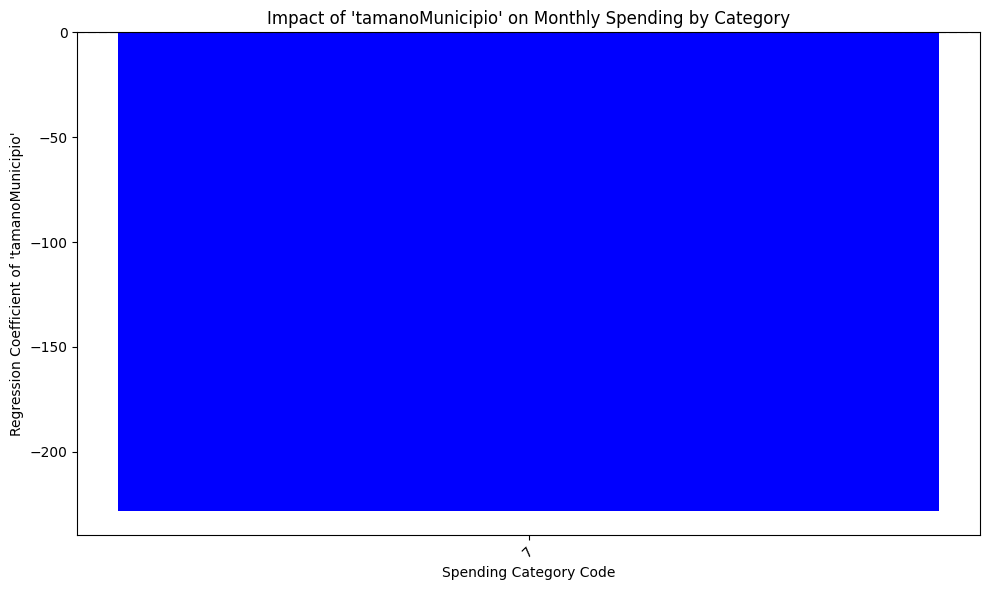

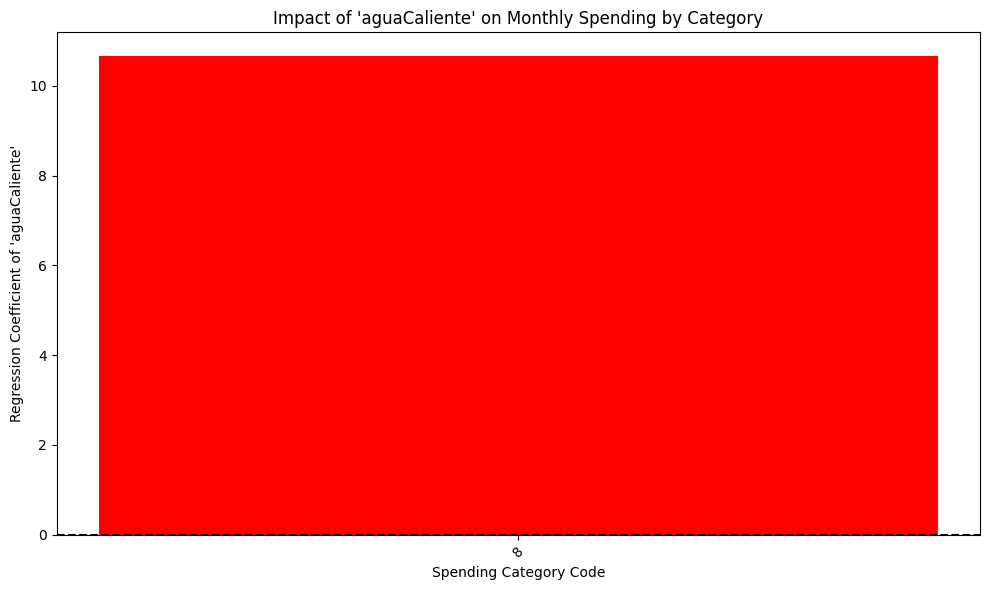

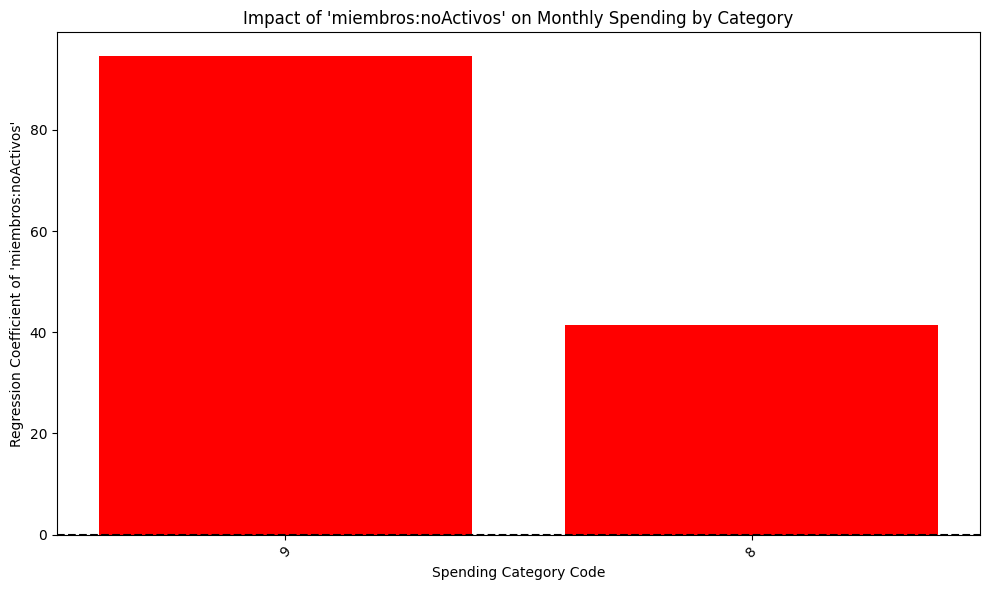

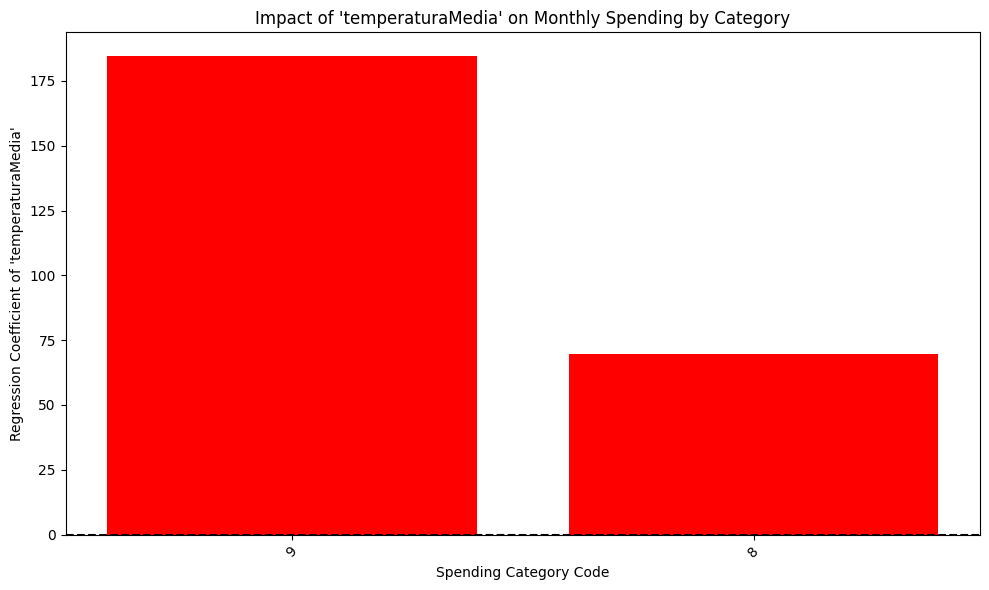

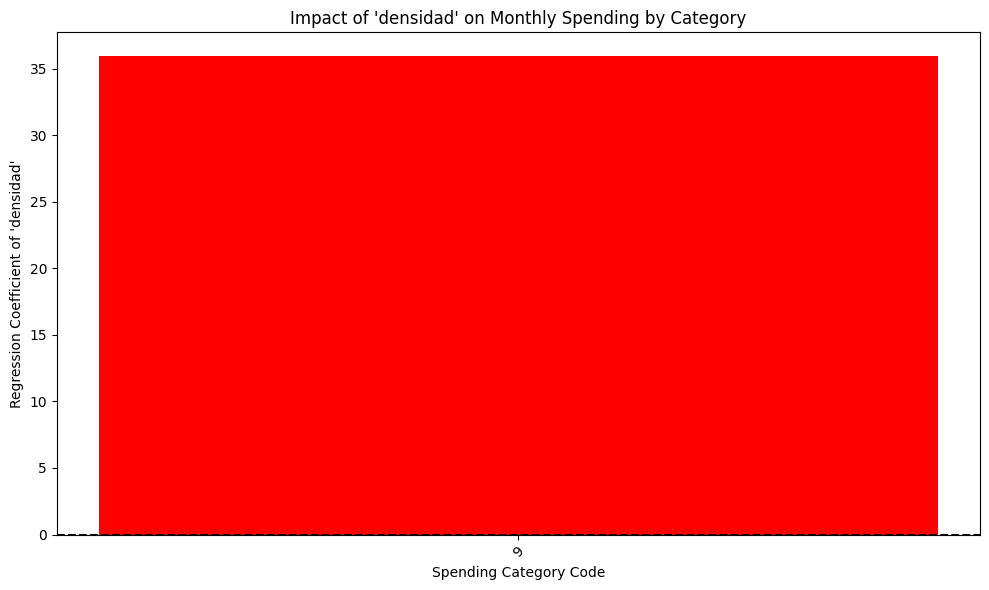

In [18]:
plot_variable_impact_across_categories(coefs_finales_without_const)

## 📊 Interpretación de un Modelo de Regresión Lineal Múltiple (sin normalizar)

### 🔍 ¿Qué significa que el modelo no esté normalizado?

En este caso, las variables **se mantienen en sus unidades originales**:

- Ingresos → en euros
- Edad → en años
- Numero de miembros del hogar (`NMIEMB`) → en número de personas
- Etc.

---

### 🎯 Interpretación de los coeficientes

Cada **coeficiente** representa el **cambio esperado en la variable dependiente (por ejemplo, gasto mensual en euros)** al aumentar en **una unidad real** la variable explicativa, manteniendo las demás constantes.

---

### 💡 Ejemplo con `NMIEMB` (Número de miembros del hogar)

El gráfico muestra el efecto de `NMIEMB` (sin normalizar) sobre el gasto mensual en cada categoría:

- En la **categoría 1 (Alimentos y bebidas no alcohólicas)**, el coeficiente es **+12** →  
  → *Cada miembro adicional en el hogar incrementa el gasto en alimentación en aproximadamente 12 euros.*

- En la **categoría 4 (Vivienda, agua, electricidad, gas)**, el coeficiente es **-7** →  
  → *Cada miembro adicional se asocia con una reducción del gasto en vivienda de unos 7 euros, posiblemente por reparto de costes fijos.*

- En la **categoría 10 (Enseñanza)**, el coeficiente es **+10** →  
  → *Hogares con más miembros suelen destinar más gasto total a educación.*

---

### ✅ Ventajas del modelo sin normalizar

- **Interpretación directa y clara**, en unidades reales (euros, años, personas...).
- Ideal cuando se quiere entender el impacto económico **real** de una variable.

---

### ⚠️ Consideraciones

- **Las escalas pueden distorsionar la comparación**: variables con unidades más grandes pueden tener coeficientes más grandes, pero no necesariamente más importantes.
- Si se quiere comparar la importancia relativa entre variables, es preferible normalizar.

---

### 🧠 Conclusión

> En modelos no normalizados, **los coeficientes reflejan el impacto real y directo de las variables** en la variable objetivo, facilitando una interpretación económica concreta.

